# ПРОЕКТ - Предсказание рисков сердечного приступа

Данный проект направлен на разработку модели, которая прогнозирует риск сердечного приступа у пациента на основе клинико-лабораторных показателей. Итог — библиотека с интерфейсом командной строки, обеспечивающая подготовку данных, обучение, инференс и формирование *.csv*-файла с предсказаниями на тестовой выборке.

---

## Описание проекта

**Задача: Предсказание риска сердечного приступа — задача бинарной классификации**

### Цель

Построить и обучить модель, которая на основе данных пациентов (антропометрия, привычки, давление, хронические заболевания, биохимия крови) возвращает вероятность **высокого** либо **низкого** риска поражения сердца.

### Данные

* `heart_train.csv` — тренировочная выборка
* `heart_test.csv` — тестовая выборка без таргета

| Признак                                          | Описание                                                   |
| ------------------------------------------------ | ---------------------------------------------------------- |
| **row\_index**                                   | Временный индекс |
| **id**                                           | Уникальный идентификатор пациента                          |
| **age**                                          | Возраст, лет                                               |
| **gender**                                       | Пол пациента (M/F)                                         |
| **systolic\_pressure**                           | Систолическое артериальное давление, мм рт. ст.            |
| **diastolic\_pressure**                          | Диастолическое артериальное давление, мм рт. ст.           |
| **heart\_rate**                                  | Частота сердечных сокращений, уд/мин                       |
| **cholesterol**                                  | Холестерин, ммоль/л                                        |
| **triglycerides**                                | Триглицериды, ммоль/л                                      |
| **blood\_sugar**                                 | Глюкоза крови, ммоль/л                                     |
| **ck\_mb**                                       | Креатинфосфокиназа-MB, нг/мл                               |
| **troponin**                                     | Тропонин, нг/мл                                            |
| **bmi**                                          | Индекс массы тела, кг/м²                                   |
| **obesity**                                      | Наличие ожирения (0 — нет, 1 — есть)                       |
| **smoking**                                      | Курение (0 — не курит, 1 — курит)                          |
| **alcohol\_consumption**                         | Употребление алкоголя                    |
| **diabetes**                                     | Наличие сахарного диабета (0/1)                            |
| **family\_history**                              | Семейный анамнез сердечных заболеваний (0/1)               |
| **previous\_heart\_problems**                    | Ранее перенесённые сердечные заболевания (0/1)             |
| **medication\_use**                              | Приём препаратов  (0/1)                               |
| **stress\_level**                                | Уровень стресса (балл 1–10)                                |
| **exercise\_hours\_per\_week**                   | Часы физической активности в неделю                        |
| **physical\_activity\_days\_per\_week**          | Дни с физической активностью в неделю                      |
| **sedentary\_hours\_per\_day**                   | Сидячие часы в день                                        |
| **sleep\_hours\_per\_day**                       | Часы сна в сутки                                           |
| **diet**                                         | Диета/план питания (категориальный индикатор 1–5)            |
| **income**                                       | Годовой доход, ед. валюты                                  |
| **heart\_attack\_risk\_binary** *(только train)* | Целевой признак: 1 — высокий риск, 0 — низкий риск         |


---

## Этапы решения задачи

1. **Загрузка данных**

   - Импорт `train.csv`, `test.csv`.
   - Первичная проверка типов и пропусков.

   


2. **Предобработка данных**

   * Выявление и удаление дублирующих признаков.
   * Обработка пропусков.


3. **Исследовательский анализ данных (EDA)**

   * Распределения признаков (гистограммы, boxplot).
   * Корреляционная матрица для количественных и категориальных признаков.
   * Анализ мультиколлинеарности.


4. **Подготовка пайплайна и обучение моделей**

   * `ColumnTransformer`:

     * **Числовые признаки**: масштабирование (`StandardScaler`,`MinMaxScaler` и др).
     * **Категориальные признаки**: кодирование категориальных признаков (`TargetEncoder` или `One-Hot`).
   * Сохранение пайплайна через `joblib`.
   
**Обучение моделей**

   * **Gradient Boosting** (`XGBoost`, `LightGBM`).
   * **Логистическая регрессия** с регуляризацией.
   * Подбор гиперпараметров с помощью `OptunaSearchCV` или `RandomizedSearchCV`.

5. **Формирование и сохранение предсказаний**

   * Сохранение лучшей модели в `prediction_results.csv` c двумя колонками: `id` и `prediction`.

6. **Выводы**


## Импортируем все необходимые библиотеки

In [2]:
!pip install optuna-integration[sklearn]

zsh:1: no matches found: optuna-integration[sklearn]


In [3]:
pip install imbalanced-learn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Общие библиотеки
import os
import sys
import warnings
import joblib
import math
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import scipy.stats as st
from scipy.stats import binom, norm, poisson
from IPython.display import display, Markdown
from scipy import stats as st

# Игнорирование предупреждений (FutureWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Установка библиотек через pip (используем только один вариант)
!"{sys.executable}" -m pip install phik -q
!pip install -q shap optuna imbalanced-learn scikit-learn

# Работа с категорическими признаками
import phik  # Для вычисления фи-коэффициента
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    LabelEncoder
)

# Работа с масштабированием и стандартизацией
from sklearn.preprocessing import (
    StandardScaler, 
    RobustScaler,  
    PolynomialFeatures,
    MinMaxScaler
)

# Обработка пропусков
from sklearn.impute import SimpleImputer

# Разделение данных
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from optuna import distributions
from optuna.integration import OptunaSearchCV

# Для выбора гиперпараметров
from optuna.distributions import IntDistribution, CategoricalDistribution, FloatDistribution

# Модели для классификации
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor

# Оценка моделей и метрики
from sklearn.metrics import (
    roc_auc_score,
    ConfusionMatrixDisplay, 
    recall_score, 
    precision_score,
    make_scorer,
    fbeta_score,
    f1_score
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as SkPipeline
from sklearn.compose import ColumnTransformer

# Для важности признаков и объясняемости
import shap
from sklearn.inspection import permutation_importance


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### 1. **Загрузка данных**
   - Импорт: `heart_train.csv`, `heart_test.csv`.
   - Первичная проверка данных.

In [5]:
pth1 = 'heart_train.csv'
pth2 = 'heart_test.csv'


if os.path.exists(pth1):
    heart_train = pd.read_csv(pth1)
else:
    print('Something is wrong')
    
if os.path.exists(pth2):
    heart_test = pd.read_csv(pth2)
else:
    print('Something is wrong')

pd.set_option('display.max_columns', None)

#### Создадим функцию для отображения всей первичной информации о датафрейме. 

In [6]:
def display_data(data, data_name='data'):
    #проверка в какой среде запускается код
    try:
        is_ipython = True
    except ImportError:
        is_ipython = False
    
    #если в юпитер наутбуке, то маркдаун, а так принт
    def md_print(text):
        if is_ipython:
            display(Markdown(text))
        else:
            print(text)
    
    # первые 5 строк датафрейма
    md_print(f"#### Первые 5 строк датафрейма `{data_name}`")
    display(data.head())
    print("\n")
    
    # информация о датафрейме
    buffer = io.StringIO()
    data.info(buf=buffer)
    info_str = buffer.getvalue()
    md_print(f"#### Общая информация о датафрейме `{data_name}`")
    print(info_str)
    print("\n")
    
    # статистическое описание датафрейма
    md_print(f"#### Статистическое описание датафрейма `{data_name}`")
    display(data.describe())

In [7]:
display_data(heart_train,'heart_train')

#### Первые 5 строк датафрейма `heart_train`

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


#### Общая информация о датафрейме `heart_train`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

#### Статистическое описание датафрейма `heart_train`

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.495380,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500008,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,0.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


In [8]:
display_data(heart_test,'heart_test')

#### Первые 5 строк датафрейма `heart_test`

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


#### Общая информация о датафрейме `heart_test`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

#### Статистическое описание датафрейма `heart_test`

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,966.00000,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,935.000000,935.000000,935.000000,966.000000,966.000000,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,482.50000,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,0.494118,0.488770,5.332620,0.506715,0.484408,0.476796,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,0.447172,0.496822,4769.160455
std,279.00448,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,0.500233,0.500141,2.858466,0.287826,0.273879,0.291987,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,0.171837,0.173935,2818.815407
min,0.00000,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,1.000000,0.001187,0.003351,0.002598,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.012903,0.116279,0.000000
25%,241.25000,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,0.000000,0.000000,3.000000,0.258713,0.261446,0.217527,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,0.296774,0.348837,2275.750000
50%,482.50000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,0.000000,0.000000,5.000000,0.501327,0.492015,0.471185,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,0.445161,0.488372,4769.500000
75%,723.75000,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,1.000000,1.000000,8.000000,0.759591,0.705371,0.720503,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,0.600000,0.639535,7206.000000
max,965.00000,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,1.000000,1.000000,10.000000,0.999033,0.998885,0.999496,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,0.741935,0.790698,9644.000000


**Проведем следующие преобразования в обоих датасетах (train, test):**

 - установим для таблицы индекс - `id`

 - Diabetes, Family History, Smoking,Obesity,Alcohol Consumption, Previous Heart Problems, Medication Use преобразуем в тип переменных `bool`, так это бинарные переменные, а тип `bool` занимает меньше памяти, чем `float`.

 - Gender оставим без изменений и закодируем в рамках создания пайплайна

 - Приведем названия колонок к нижнему регистру

 - таргет - высокий или низкий риск поражения сердца 'heart attack risk (binary)' преобразуем также в бинарный отдельно

 - возраст в обоих датафреймах домножим на 100 и преобразуем  int

 - частоту сердечных сокращений (Heart rate) измеряют в уд/минуту, поэтому данные нужно домножить на тысячу, чтобы это соотносилось с реальностью


In [9]:
columns_to_tranform =['Diabetes', 'Family History', 'Smoking','Obesity','Alcohol Consumption',\
                       'Previous Heart Problems', 'Medication Use']

for df in (heart_train, heart_test):

    df.drop(columns='Unnamed: 0',  inplace=True)

    # преобразуем вышеупомянутые колонки в тип bool
    for col in columns_to_tranform:
        if col in df.columns:
            df[col] = df[col].astype(bool)
    
    # ставим id в индекс
    df.set_index('id', inplace=True)

    #приводим все имена столбцов к нижнему регистру
    df.columns = df.columns.str.lower()

In [10]:
heart_train['heart attack risk (binary)'] = heart_train['heart attack risk (binary)'].astype(bool)

**Проверим получившиеся преобразования**

In [11]:
#используем функцию с именнованными аргументами, чтобы разграничить все 3 датафрейма с помощью названий
def print_dtypes(**named_dataframes):
    for name, df in named_dataframes.items():
        print(f"{name}:\n{df.dtypes}\n{'-' * 30}")

print_dtypes(
    heart_train=heart_train,
    heart_test=heart_test
)

heart_train:
age                                float64
cholesterol                        float64
heart rate                         float64
diabetes                              bool
family history                        bool
smoking                               bool
obesity                               bool
alcohol consumption                   bool
exercise hours per week            float64
diet                                 int64
previous heart problems               bool
medication use                        bool
stress level                       float64
sedentary hours per day            float64
income                             float64
bmi                                float64
triglycerides                      float64
physical activity days per week    float64
sleep hours per day                float64
heart attack risk (binary)            bool
blood sugar                        float64
ck-mb                              float64
troponin                           float6

**Выводы после первичного изнакомления с данными:** 

  - Данные импортированы. 
    
  - Выведены первые строки каждого набора данных. 
  
  - В датафреймах имеются некоторое кол-во пропусков, которые изучим на следующем этапе, что свидетельствует о достатоночно высокой полноте данных.
  
  - Все наименования признаков (столбцов) представлены в "змеином регистре". 
  
  - Часть данных имели некорректный тип с точки зрения их корректности, информативности и эффективности. На следующем этапе обработаем пропуски и дубликаты в случае их наличия.

  - **видно, что все количесвтенные данные (непрервные) были нормированы, так как данные находятся в диапазоне от 0 до 1**, однако, мы не можем знать, все ли данные были отмасштабированы одним и тем же скейлером, поэтому мы не можем привести к реально полученным данным.




### 2. **Предобработка данных**
  



**Проверим наличие уникальных категориальных значений** 

In [12]:
dfs = {
    'heart_train': heart_train,
    'heart_test': heart_test
}

for name, d in dfs.items():
    print(f"DataFrame: {name}")
    for column in d.columns:
        if d[column].dtype in ['float64']:
            continue
        print(f"Столбец: {column}")
        print(d[column].value_counts(), '\n')

DataFrame: heart_train
Столбец: diabetes
diabetes
True     5748
False    2937
Name: count, dtype: int64 

Столбец: family history
family history
True     4376
False    4309
Name: count, dtype: int64 

Столбец: smoking
smoking
True     7865
False     820
Name: count, dtype: int64 

Столбец: obesity
obesity
True     4450
False    4235
Name: count, dtype: int64 

Столбец: alcohol consumption
alcohol consumption
True     5325
False    3360
Name: count, dtype: int64 

Столбец: diet
diet
1    2863
2    2796
0    2783
3     243
Name: count, dtype: int64 

Столбец: previous heart problems
previous heart problems
True     4425
False    4260
Name: count, dtype: int64 

Столбец: medication use
medication use
True     4474
False    4211
Name: count, dtype: int64 

Столбец: heart attack risk (binary)
heart attack risk (binary)
False    5672
True     3013
Name: count, dtype: int64 

Столбец: gender
gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64 

DataFra

**Преобразуем `male` в 1, `female` в 0, затем преобразуем все тип int**

In [13]:
for df in (heart_train, heart_test):
    df['gender'] = df['gender'].replace({'Male':1,'Female':0, '1.0':1,'0.0':0}).astype(int)

**Проверим наличие явных дубликатов** 

In [14]:
#Создадим функцию для отображения и удаления явных дубликатов в каждом датафрейме.
def dup_entities_multiple(*dfs,keep="first"):
    cleaned = []
    for i, df in enumerate(dfs, start=1):
        num_duplicates = df.duplicated(keep=keep).sum()
        print(f"[DataFrame {i}] Количество дубликатов: {num_duplicates}")
        if num_duplicates > 0:
            df = df.drop_duplicates(keep=keep)
            print(f"[DataFrame {i}] Дубликаты удалены.")
        else:
            print(f"[DataFrame {i}] Дубликаты отсутствуют.")
        cleaned.append(df)
    return cleaned

heart_train, heart_test = dup_entities_multiple(
    heart_train, 
    heart_test
)

[DataFrame 1] Количество дубликатов: 0
[DataFrame 1] Дубликаты отсутствуют.
[DataFrame 2] Количество дубликатов: 0
[DataFrame 2] Дубликаты отсутствуют.


**Посмотрим на пропущенные значения** 

In [15]:
def missing_values_report(data):
    report = data.isna().sum().to_frame()
    report = report.rename(columns={0: 'missing_values'})
    report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
    report = report.sort_values(by='missing_values', ascending=False)
    return report

In [16]:
missing_values_report(heart_train)

,missing_values,% of total
physical activity days per week,243,0.03
stress level,243,0.03
age,0,0.00
income,0,0.00
systolic blood pressure,0,0.00
gender,0,0.00
troponin,0,0.00
ck-mb,0,0.00
blood sugar,0,0.00
heart attack risk (binary),0,0.00


In [17]:
missing_values_report(heart_test)

,missing_values,% of total
stress level,31,0.03
physical activity days per week,31,0.03
sedentary hours per day,0,0.00
systolic blood pressure,0,0.00
gender,0,0.00
troponin,0,0.00
ck-mb,0,0.00
blood sugar,0,0.00
sleep hours per day,0,0.00
triglycerides,0,0.00


Как видно, в обоих датасетах, присутсвуют незначительное количество пропусков в данных `physical activity days per week` и `stress level`. `stress level` представлен категориальным признаком, который закодируем позже в рамках `Ordinal Encoder`, воспользуемся `strategy='most_frequent'`. `physical activity days per week` в целом можем не трогать, а просто не брать этот признак в дальнейшем для обучения модели, так как в датасете представлен признак `exercise hours per week`, который также учитывает физическую активность и даже без корреляционной матрицы понятно, что они будут коррелировать. Аналогичную параллеь можно провести с `sedentary hours per day` и `sleep hours per day`, `physical activity days per week` может быть получен как разница 24 часов минус сон и сидячие часы. Поэтому с соответсвующими пропусками не будем ничего делать.

**Промежуточные выводы по предобработке данных**

   - В ходе предбработки данных была проведена проверка датафреймов на наличие пропущенных значений и дубликатов. 

   - Было обнаружено небольшое кол-во пропусков, которые не затруднят процесс обучения и будут обработаны в рамках пайплайна.



Перед тем, как перейти как чистке выбросов и удалению аномальных данных, сохраним первоначальное кол-во данных (объем), которые после обработки и чистки  должны быть не более чем на 10% меньше, чем изначальный датасет.

In [18]:
row_train, row_test = heart_train.shape[0], heart_test.shape[0]
row_train, row_test

(8685, 966)

### 3. **Исследовательский анализ данных**
   - Построение статистических сводок и визуализаций (гистограммы, boxplot, scatter plot) для каждого признака.
   - Анализ взаимосвязей между признаками и целевым признаком.
   - Проверка на мультиколлинеарность. 
   - Формулировка выводов для подготовки данных к моделированию.



**Создадим функции для подчета статистических показателей.** 

In [19]:
#создадим функцию для непрерывных
def compare_quantity_analysis(df1, df2,col,title=None, bins=30):
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # для первого столбца
    df1[col].hist(bins=bins, ax=axes[0, 0])
    axes[0, 0].set_title(f'Гистограмма распределения\n {title} в тренировочной выборке', fontsize=12)
    axes[0, 0].set_xlabel(col, fontsize=10)
    axes[0, 0].set_ylabel('Количество наблюдений', fontsize=10)
    
    # для второго столбца
    df2[col].hist(bins=bins, ax=axes[0, 1])
    axes[0, 1].set_title(f'Гистограмма распределения\n {title} в тестовой выборке', fontsize=12)
    axes[0, 1].set_xlabel(col, fontsize=10)
    axes[0, 1].set_ylabel('Количество наблюдений', fontsize=10)
    
    # Boxplot для первого столбца
    df1.boxplot(column=col, ax=axes[1, 0])
    axes[1, 0].set_title(f'Boxplot {title}\n для тренировочной выборки', fontsize=12)
    
    # Boxplot для второго столбца
    df2.boxplot(column=col, ax=axes[1, 1])
    axes[1, 1].set_title(f'Boxplot {title}\n для тестовой выборки', fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [20]:
#функция для категориальных признаков 
def compare_cat_characteristics(df1, df2, col, title=None, figsize=(12, 6)):
    
    counts1 = df1[col].value_counts()
    counts2 = df2[col].value_counts()
    

    def func(pct, allvals):
        absolute = round(pct / 100. * np.sum(allvals))
        return f"{pct:.1f}%\n({absolute})"
    

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    

    axes[0].pie(counts1, labels=counts1.index, autopct=lambda pct: func(pct, counts1),
                startangle=90, colors=plt.cm.Paired.colors)
    axes[0].set_title(f'{title if title is not None else col} в тренировочной выборке', fontsize=14)

    axes[1].pie(counts2, labels=counts2.index, autopct=lambda pct: func(pct, counts2),
                startangle=90, colors=plt.cm.Paired.colors)
    axes[1].set_title(f'{title if title is not None else col} в тренировочной выборке', fontsize=14)

    
    plt.tight_layout()
    plt.show()

In [21]:
#создадим функцию для работы с дискретными
def discrete_comparison(df_1, df_2, col, title=None, bins=None, labels=None):
    
    binned_col_1 = pd.cut(df_1[col], bins=bins, labels=labels, include_lowest=True)
    binned_col_2 = pd.cut(df_2[col], bins=bins, labels=labels, include_lowest=True)
    

    order_1 = labels
    order_2 = labels

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # для col_1 
    sns.countplot(x=binned_col_2, data=df_1, ax=axes[0], palette='Blues', order=order_1)
    axes[0].set_title(f'Распределение {title} \nв тренировочной выборке', fontsize=16)
    axes[0].set_xlabel(col, fontsize=14)
    axes[0].set_ylabel('Количество наблюдений', fontsize=14)
    axes[0].grid(axis='y', alpha=0.75)
    
    # для col_2 
    sns.countplot(x=binned_col_2,data=df_2, ax=axes[1], palette='Oranges', order=order_2)
    axes[1].set_title(f'Распределение {title} \nв тестовой выборке', fontsize=16)
    axes[1].set_xlabel(col, fontsize=14)
    axes[1].set_ylabel('Количество наблюдений', fontsize=14)
    axes[1].grid(axis='y', alpha=0.75)
    
    plt.tight_layout()
    plt.show()


In [22]:
#для определения границ ящика с учами воспользуемся формулой для расчета границ выбросов с использованием
#межквартильного размаха (IQR). Создадим функцию, которую будем в дальнейшем не раз вызывать.
def borders(data,column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    # границы для выбросов
    lower_bound = round(Q1 - 1.5 * IQR,4)
    upper_bound = round(Q3 + 1.5 * IQR,4)
    print(f"Размах \"усов\": \n1)нижняя граница: {lower_bound}\n2)верхняя граница: {upper_bound}")
    print(f"Межквартальный размах: \n1)нижняя граница: {Q1}\n2)верхняя граница: {Q3}")

In [23]:
heart_train.columns

Index(['age', 'cholesterol', 'heart rate', 'diabetes', 'family history',
       'smoking', 'obesity', 'alcohol consumption', 'exercise hours per week',
       'diet', 'previous heart problems', 'medication use', 'stress level',
       'sedentary hours per day', 'income', 'bmi', 'triglycerides',
       'physical activity days per week', 'sleep hours per day',
       'heart attack risk (binary)', 'blood sugar', 'ck-mb', 'troponin',
       'gender', 'systolic blood pressure', 'diastolic blood pressure'],
      dtype='object')

**Признаки, которые стоит детально изучить в `heart_train` и `heart_test`**

* [x] `age` — возраст пациента (в годах) — дискретный
* [x] `cholesterol` — уровень холестерина, ммоль/л — непрерывный
* [x] `heart rate` — частота сердечных сокращений, уд/мин — дискретный
* [x] `diabetes` — наличие сахарного диабета (0 — нет, 1 — есть) — бинарный
* [x] `family history` — семейный анамнез сердечных заболеваний (0 — нет, 1 — есть) — бинарный
* [x] `smoking` — курение (0 — не курит, 1 — курит) — бинарный
* [x] `obesity` — наличие ожирения (0 — нет, 1 — есть) — бинарный
* [x] `alcohol consumption` — потребление алкоголя, порций/неделю — дискретный
* [x] `exercise hours per week` — часы физической активности в неделю — непрерывный
* [x] `diet` — качество рациона (оценка 1–5) — категориальный
* [x] `previous heart problems` — ранее перенесённые сердечные заболевания (0/1) — бинарный
* [x] `medication use` — приём препаратов (0/1) — бинарный
* [x] `stress level` — уровень стресса (балл 1–10) — дискретный
* [x] `sedentary hours per day` — сидячие часы в день — непрерывный
* [x] `income` — уровень дохода — непрерывный
* [x] `bmi` — индекс массы тела, кг/м² — непрерывный
* [x] `triglycerides` — уровень триглицеридов, ммоль/л — непрерывный
* [x] `physical activity days per week` — кол-вол дней с физической активностью в неделю — дискретный
* [x] `sleep hours per day` — часы сна в сутки — непрерывный
* [x] `blood sugar` — уровень сахара (глюкозы) в крови, ммоль/л — непрерывный
* [x] `ck-mb` — креатинфосфокиназа-MB, нг/мл — непрерывный
* [x] `troponin` — тропонин, нг/мл — непрерывный
* [x] `gender` — пол пациента (M/F) — категориальный
* [x] `systolic blood pressure` — систолическое АД, мм рт. ст. — непрерывный
* [x] `diastolic blood pressure` — диастолическое АД, мм рт. ст. — непрерывный

Уникальный для тренировочной выборки (heart_train).
* [x] `heart attack risk (binary)` — целевой признак: 1 — высокий риск, 0 — низкий риск — бинарный


In [24]:
bin_years = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]
label_years = ['0–0.10', '0.10–0.20', '0.20–0.30', '0.30–0.40', '0.40–0.50', '0.50–0.60', '0.60–0.70', '0.80-0.90','0.90-1']

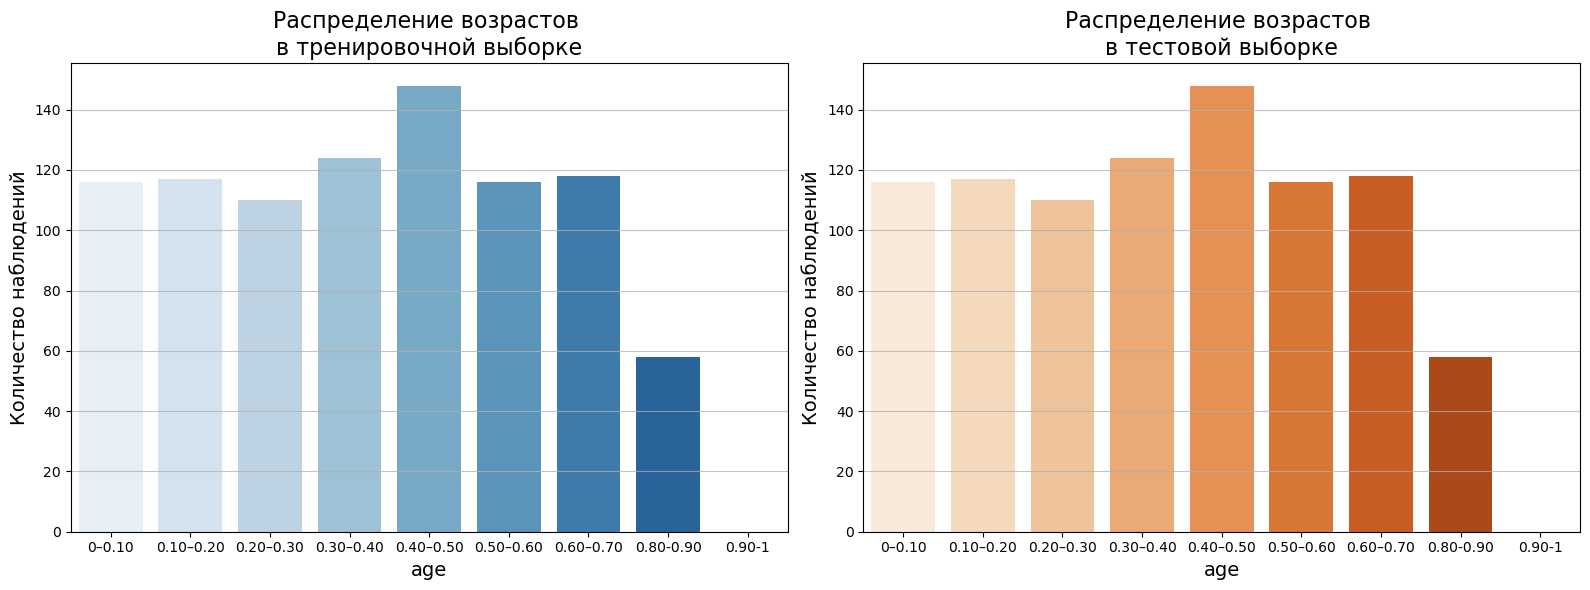

In [25]:
discrete_comparison(heart_train, heart_test, 'age','возрастов',bin_years, label_years)

Оба датасета имеют одинаковое кол-во распределение возрастов, видно, что есть 3 пика. То есть в данных предсталвены сразу 3 возрастые группы: дети, взрослые и пожилые, что характерирзует возраст как признак с выокой полнотой, у нас нет перекоса в сторону только пожилых или только взрослых.

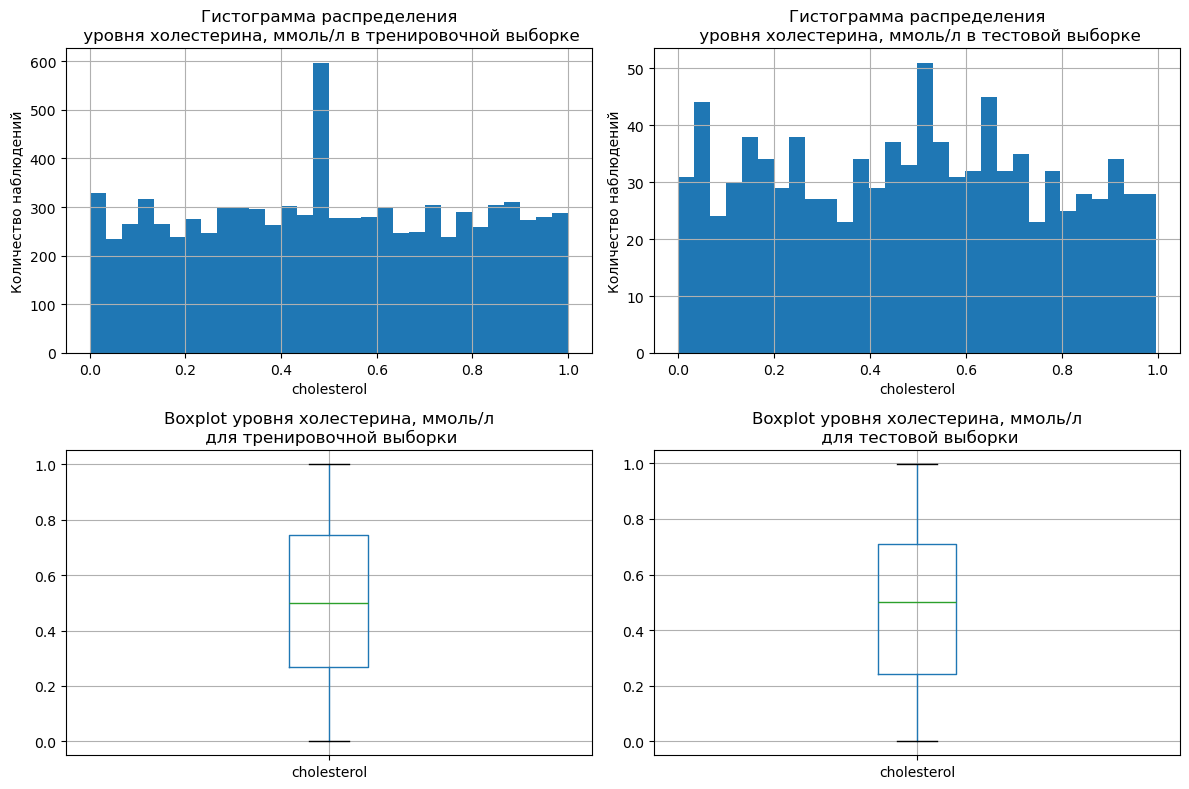

In [26]:
compare_quantity_analysis(heart_train,heart_test,'cholesterol','уровня холестерина, ммоль/л')

In [27]:
borders(heart_train,'cholesterol')

Размах "усов": 
1)нижняя граница: -0.45
2)верхняя граница: 1.4643
Межквартальный размах: 
1)нижняя граница: 0.2678571428571428
2)верхняя граница: 0.7464285714285714


In [28]:
borders(heart_test,'cholesterol')

Размах "усов": 
1)нижняя граница: -0.4567
2)верхняя граница: 1.4112
Межквартальный размах: 
1)нижняя граница: 0.2437499999999999
2)верхняя граница: 0.7107142857142856


**Для понимания качества данных следует воспользоваться интернетом, чтобы получить понимание о том, что является нормой, что выбросом**

Материал был взят с сайта клиники: [https://medyunion.ru/blog/kholesterin-normalnyy-nizkiy-i-vysokiy-normy-dlya-vzroslykh-i-detey/]

**Норма холестерина у мужчин**

| Возраст         | Показатель, ммоль/л |
| --------------- | ------------------- |
| 20–30 лет       | 3,21–6,32           |
| 30–40 лет       | 3,57–6,99           |
| 40–50 лет       | 3,91–7,15           |
| 50–60 лет       | 4,09–7,15           |
| 60–70 лет       | 4,12–7,10           |
| 71 год и старше | 3,73–6,86           |

---

**Норма холестерина у женщин**

| Возраст         | Показатель, ммоль/л |
| --------------- | ------------------- |
| 20–30 лет       | 3,16–5,75           |
| 30–40 лет       | 3,37–6,27           |
| 40–50 лет       | 3,81–6,86           |
| 50–60 лет       | 4,20–7,70           |
| 60–70 лет       | 4,45–7,85           |
| 71 год и старше | 4,48–7,25           |

---

То есть норма холестирина у мужчин и женщиин разнится, при этом в среднем норма у женщин на несколько десятых ниже, чем у мужчин при возрастном делении.

Как видно из гистограммы, данные распределены равномерно, что связано с тем, что и возрастые группы представлены равномерно, нет перекосов, поэтому и уровень холестерина соотвествует этим группам. Исходя из графика "Ящик с усами" мы видим, что аномалий нет, а межквартальный рахмах в обоих выборках находится в пределах [0.24, 0.75] для обоих датасетов.

Рассмотрим теперь распределение холестирина при группировке по полу и по возрастам.

Создадим функцию, которая будет выдавать распределение каких-либо медицинских показателей по полу и по возрасту, так как в датасете такие признаки представлены несколько раз и различные показатели, а именно норма того или иного показателя определяется во первых полом, а вторых возрастом.

In [29]:
def medical_comparison(df, value_to_calculate):

    bin_edges = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]
    bin_labels = ['0–0.10', '0.10–0.20', '0.20–0.30', '0.30–0.40', '0.40–0.50', '0.50–0.60', '0.60–0.70', '0.80-0.90','0.90-1']

    # мужчины
    man_values = df.loc[df['gender'] == 1, ['age', value_to_calculate]]

    #женщины
    woman_values = df.loc[df['gender'] == 0, ['age', value_to_calculate]]

    man_bins = pd.cut(man_values['age'], bins=bin_edges, labels=bin_labels, include_lowest=True)
    woman_bins = pd.cut(woman_values['age'], bins=bin_edges, labels=bin_labels, include_lowest=True)


    men_stats = man_values.assign(age_group=man_bins).groupby('age_group')[value_to_calculate].agg(['mean', 'median']).reindex(bin_labels)

    women_stats = woman_values.assign(age_group=woman_bins).groupby('age_group')[value_to_calculate].agg(['mean', 'median']).reindex(bin_labels)

    print(f"\nРаспределение «{value_to_calculate}» по возрастным группам для мужчин:\n")
    display(men_stats)
    print(f"\nРаспределение «{value_to_calculate}» по возрастным группам для женщин:\n")
    display(women_stats)


In [30]:
medical_comparison(heart_train, 'cholesterol')


Распределение «cholesterol» по возрастным группам для мужчин:



,mean,median
age_group,,
0–0.10,0.521848,0.525000
0.10–0.20,0.513533,0.507143
0.20–0.30,0.499311,0.499780
0.30–0.40,0.506910,0.499780
0.40–0.50,0.494485,0.499780
0.50–0.60,0.491921,0.499780
0.60–0.70,0.500639,0.499780
0.80-0.90,0.480390,0.455357
0.90-1,0.499780,0.499780



Распределение «cholesterol» по возрастным группам для женщин:



,mean,median
age_group,,
0–0.10,0.481482,0.442857
0.10–0.20,0.501233,0.499780
0.20–0.30,0.489592,0.478571
0.30–0.40,0.485508,0.499780
0.40–0.50,0.518067,0.499780
0.50–0.60,0.514091,0.505357
0.60–0.70,0.508220,0.507143
0.80-0.90,0.526119,0.510714
0.90-1,0.499780,0.499780


In [31]:
medical_comparison(heart_test, 'cholesterol')


Распределение «cholesterol» по возрастным группам для мужчин:



,mean,median
age_group,,
0–0.10,0.459687,0.489286
0.10–0.20,0.546795,0.569643
0.20–0.30,0.484470,0.499780
0.30–0.40,0.469614,0.499780
0.40–0.50,0.473774,0.499780
0.50–0.60,0.544717,0.558929
0.60–0.70,0.446918,0.442857
0.80-0.90,0.474336,0.432143
0.90-1,NaN,NaN



Распределение «cholesterol» по возрастным группам для женщин:



,mean,median
age_group,,
0–0.10,0.473313,0.416071
0.10–0.20,0.570049,0.603571
0.20–0.30,0.471610,0.460714
0.30–0.40,0.470587,0.496429
0.40–0.50,0.581786,0.671429
0.50–0.60,0.473082,0.476676
0.60–0.70,0.423413,0.364286
0.80-0.90,0.384524,0.278571
0.90-1,NaN,NaN


In [32]:
heart_train['cholesterol'].describe().T, heart_test['cholesterol'].describe().T

(count    8685.000000
 mean        0.501070
 std         0.284716
 min         0.000000
 25%         0.267857
 50%         0.499780
 75%         0.746429
 max         1.000000
 Name: cholesterol, dtype: float64,
 count    966.000000
 mean       0.488181
 std        0.282039
 min        0.000000
 25%        0.243750
 50%        0.499780
 75%        0.710714
 max        0.996429
 Name: cholesterol, dtype: float64)

Сравнивая полученные данные с нормами, можно считать, что данные соотвествуют действительности и нет каких-то аномальных выбросов или аномалий при условии, что данные были, например, разделены на 10. Однако, это необязательное условие, но исходя из статитистических показатей данные находятся в пределах усов и никаких выбросов не наблюдается.

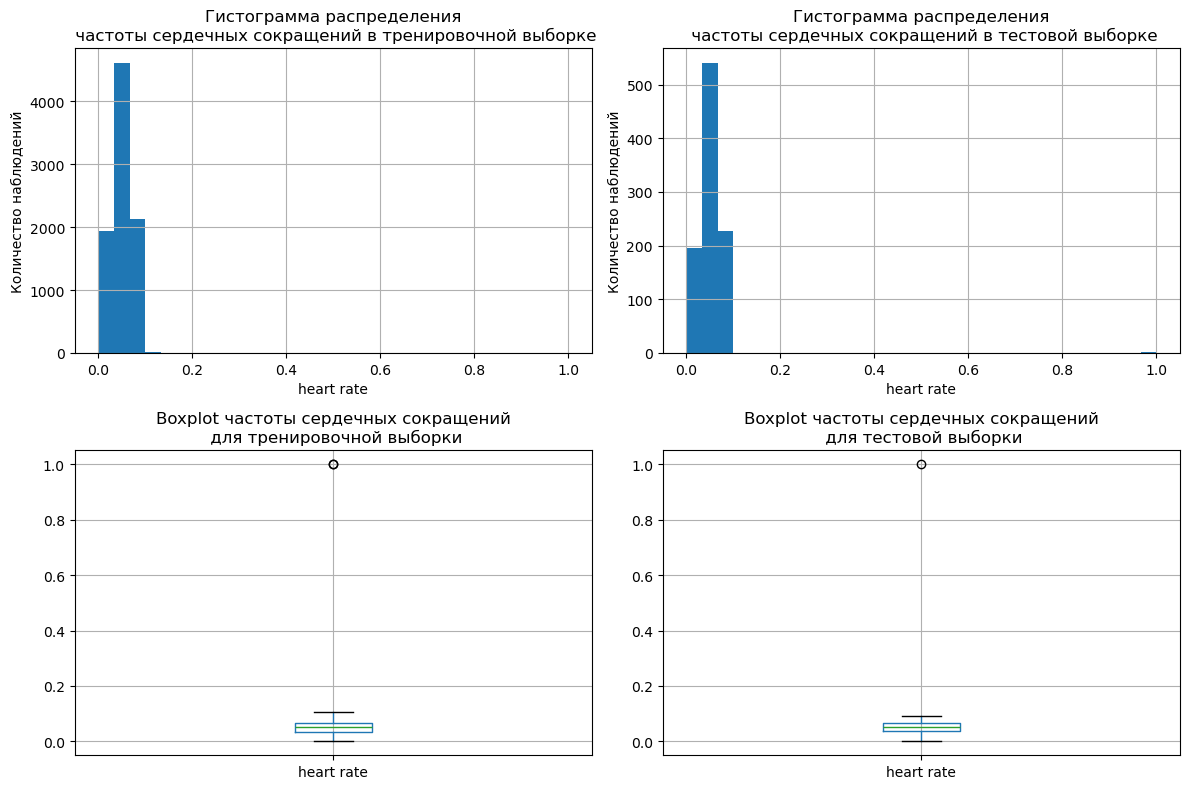

In [33]:
compare_quantity_analysis(heart_train,heart_test,'heart rate','частоты сердечных сокращений', bins=30)

Видим выброс на уровне 1, проверим сколько данных приходится на выбросы, то есть больше 0,15 (например, ударов в минуту, но после масштабирования), и меньше 0,02 например. Нормальная частота сердечных сокращений колеблется от 60 до 100 ударов в минуту. 

Так как мы не имеем доступа к скейлеру, который применялся для масштабирования или же нормирования данных, воспользуемся гистограммами и межкваратльным размахом.

Тут и ниже будет указано ударов в минуту, что имеет интерпретацию с точки зрения самого признака в реальной жизни.

In [34]:
portion_train = heart_train[(heart_train['heart rate'] > 0.15)|(heart_train['heart rate'] < 0.02)].shape[0] / heart_train.shape[0] * 100
portion_test = heart_test[(heart_test['heart rate'] > 0.15)|(heart_test['heart rate'] < 0.02)].shape[0] / heart_test.shape[0] * 100
print(f'Доля данных в тренировочной выборке, где частота удоров выше 0.15 и меньше 0.2 (ударов в минуту): {portion_train:.2f}%')
print(f'Доля данных в тестовой выборке, где частота удоров выше 0.15 и меньше 0.2 (ударов в минуту): {portion_test:.2f}%')

Доля данных в тренировочной выборке, где частота удоров выше 0.15 и меньше 0.2 (ударов в минуту): 2.69%
Доля данных в тестовой выборке, где частота удоров выше 0.15 и меньше 0.2 (ударов в минуту): 2.38%


Избавимся от этих выбросов и вновь посмотрим на распределение данного признака.

In [35]:
heart_train = heart_train[(heart_train['heart rate'] <= 0.15) & (heart_train['heart rate'] > 0.02)]

heart_test = heart_test[(heart_test['heart rate'] <= 0.15) & (heart_test['heart rate'] > 0.02)]

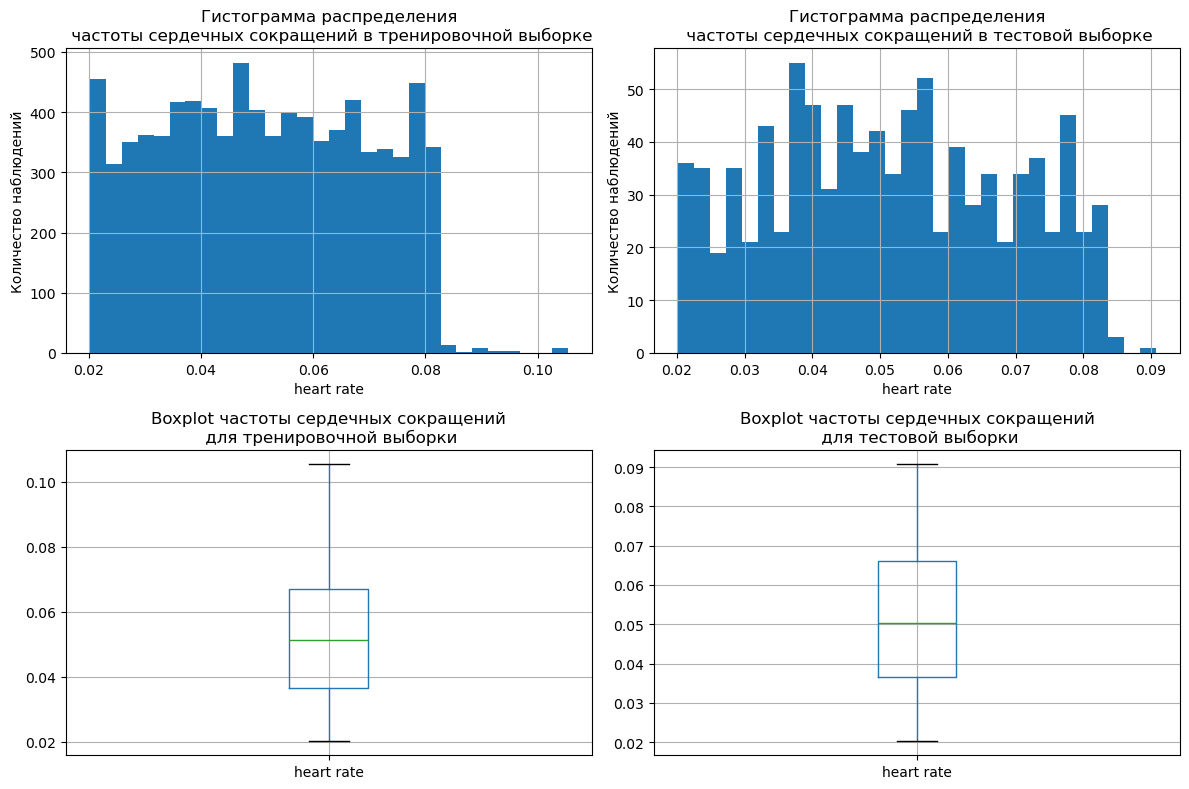

In [36]:
compare_quantity_analysis(heart_train,heart_test,'heart rate','частоты сердечных сокращений')

In [37]:
medical_comparison(heart_train, 'heart rate')


Распределение «heart rate» по возрастным группам для мужчин:



,mean,median
age_group,,
0–0.10,0.051071,0.051329
0.10–0.20,0.051161,0.050871
0.20–0.30,0.052246,0.052246
0.30–0.40,0.051774,0.050412
0.40–0.50,0.051252,0.049496
0.50–0.60,0.050016,0.049496
0.60–0.70,0.051870,0.052246
0.80-0.90,0.050512,0.051329
0.90-1,0.036664,0.036664



Распределение «heart rate» по возрастным группам для женщин:



,mean,median
age_group,,
0–0.10,0.051821,0.051329
0.10–0.20,0.051518,0.052246
0.20–0.30,0.051857,0.051329
0.30–0.40,0.050851,0.050412
0.40–0.50,0.051131,0.052246
0.50–0.60,0.050125,0.049496
0.60–0.70,0.053568,0.056829
0.80-0.90,0.052294,0.054079
0.90-1,0.046746,0.046746


In [38]:
medical_comparison(heart_test, 'heart rate')


Распределение «heart rate» по возрастным группам для мужчин:



,mean,median
age_group,,
0–0.10,0.052031,0.053162
0.10–0.20,0.051270,0.051329
0.20–0.30,0.050917,0.047663
0.30–0.40,0.051406,0.050412
0.40–0.50,0.051034,0.048579
0.50–0.60,0.051963,0.050412
0.60–0.70,0.054983,0.052704
0.80-0.90,0.046831,0.043080
0.90-1,NaN,NaN



Распределение «heart rate» по возрастным группам для женщин:



,mean,median
age_group,,
0–0.10,0.054699,0.054079
0.10–0.20,0.057557,0.059578
0.20–0.30,0.045626,0.041247
0.30–0.40,0.050506,0.054079
0.40–0.50,0.055576,0.056370
0.50–0.60,0.050785,0.051787
0.60–0.70,0.049142,0.052246
0.80-0.90,0.045689,0.041247
0.90-1,NaN,NaN


In [39]:
borders(heart_train,'heart rate')
borders(heart_test,'heart rate')

Размах "усов": 
1)нижняя граница: -0.0087
2)верхняя граница: 0.1123
Межквартальный размах: 
1)нижняя граница: 0.0366636113657195
2)верхняя граница: 0.0669110907424381
Размах "усов": 
1)нижняя граница: -0.0073
2)верхняя граница: 0.11
Межквартальный размах: 
1)нижняя граница: 0.0366636113657195
2)верхняя граница: 0.0659945004582951


Избавились от выбросов с помощью графика "Ящик с усами" и показали их распределение для мужчин и женщин при разбиении на группы по возрастам. Не смотря на то, что данные были получены уже отмасштабированные, мы видим, что данные попадают в доверительный интервал, а значения среднее и медиана в каждой группе находится примерно на одном и том же уровне.

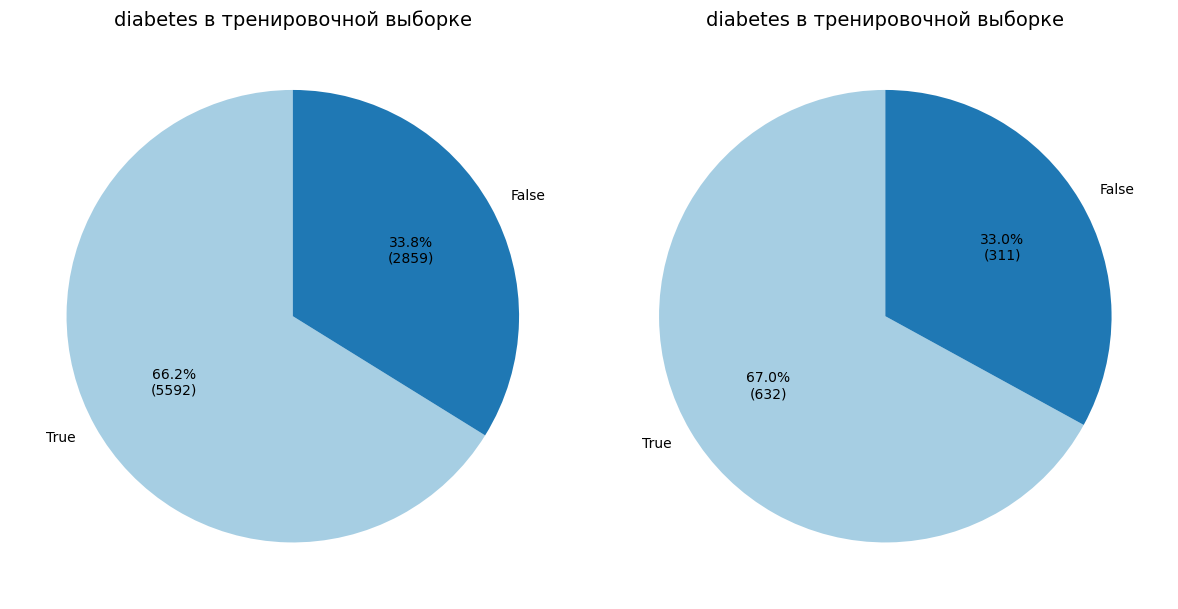

In [40]:
compare_cat_characteristics(heart_train, heart_test, 'diabetes')

Исходя из круговой диаграмы, видно, что данные в обеих выборках имеют одинаковое распределение. Однако, данные имеют небольшой дизбаланс классов, который будет обрабом в случае неудовлетворительных метрик, с помощью, например, SMOTE,RandomUnderSampler или SMOTEENN.

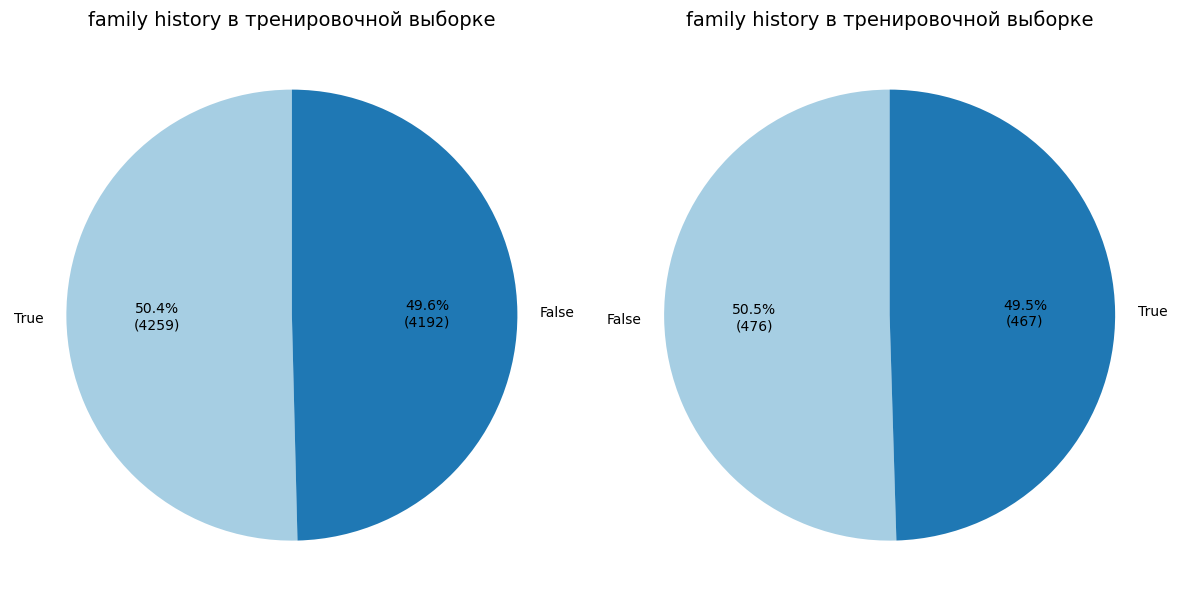

In [41]:
compare_cat_characteristics(heart_train, heart_test, 'family history')

Что касается показателя family history, то данные распределены равномерно, а дисбаланс отсуствует.

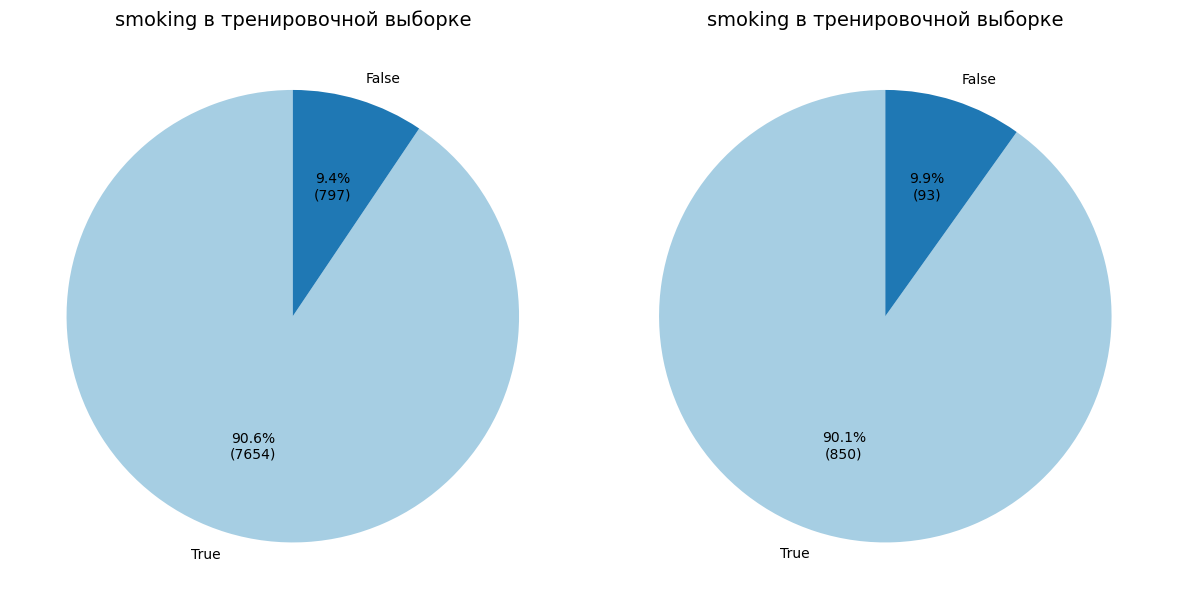

In [42]:
compare_cat_characteristics(heart_train, heart_test, 'smoking')

В данных по больше части представлены люди, которые курят, что может сильно повлиять на результат модели. То есть уже сейчас можно сказать, что курение будет оказывать влияние на результат модели. В данном случае, лучше произвести сэмплирование данных. 

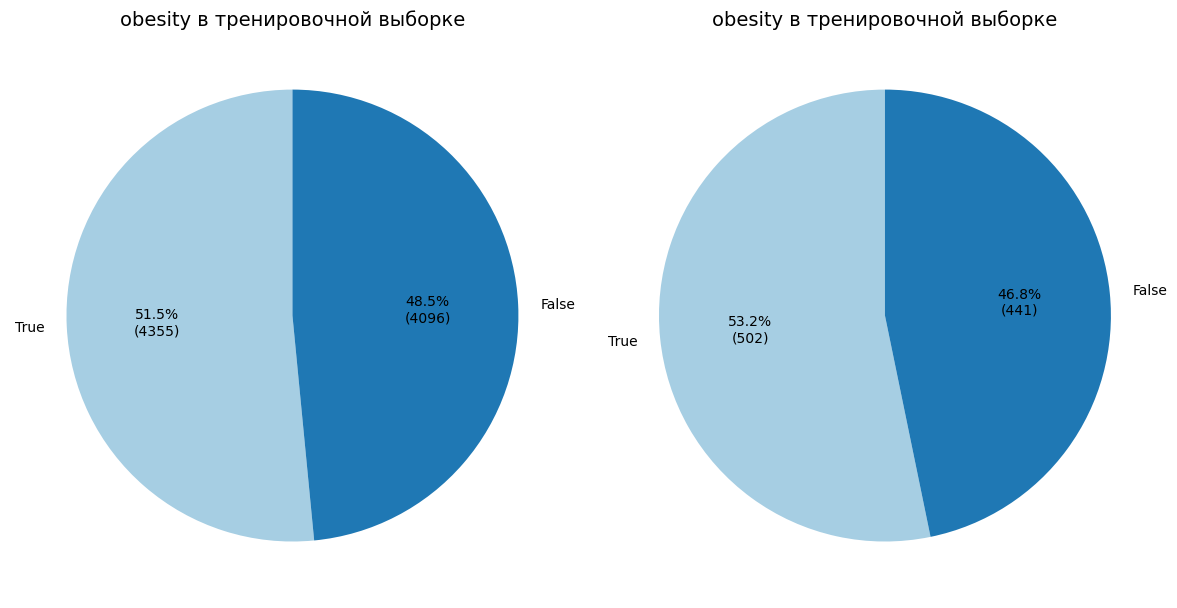

In [43]:
compare_cat_characteristics(heart_train, heart_test, 'obesity')

Что касается показателя obesity, то данные распределены равномерно, а дисбаланс отсуствует.

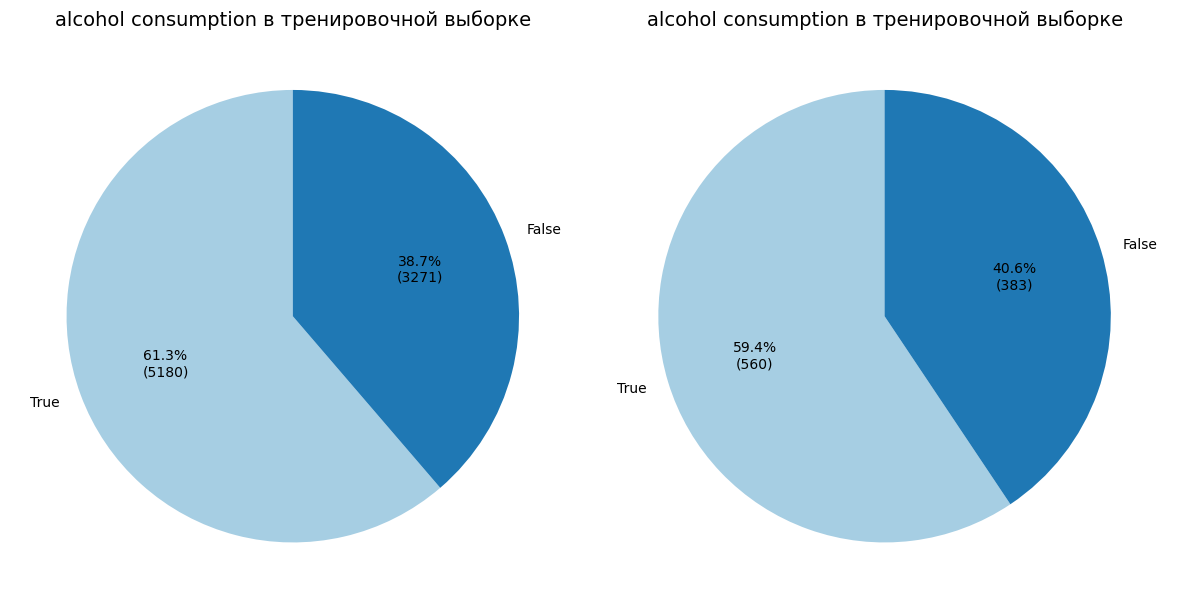

In [44]:
compare_cat_characteristics(heart_train, heart_test, 'alcohol consumption')

Аналогичная ситуация с потреблением алкоголя, решим проблему в рамках пайплайна. 

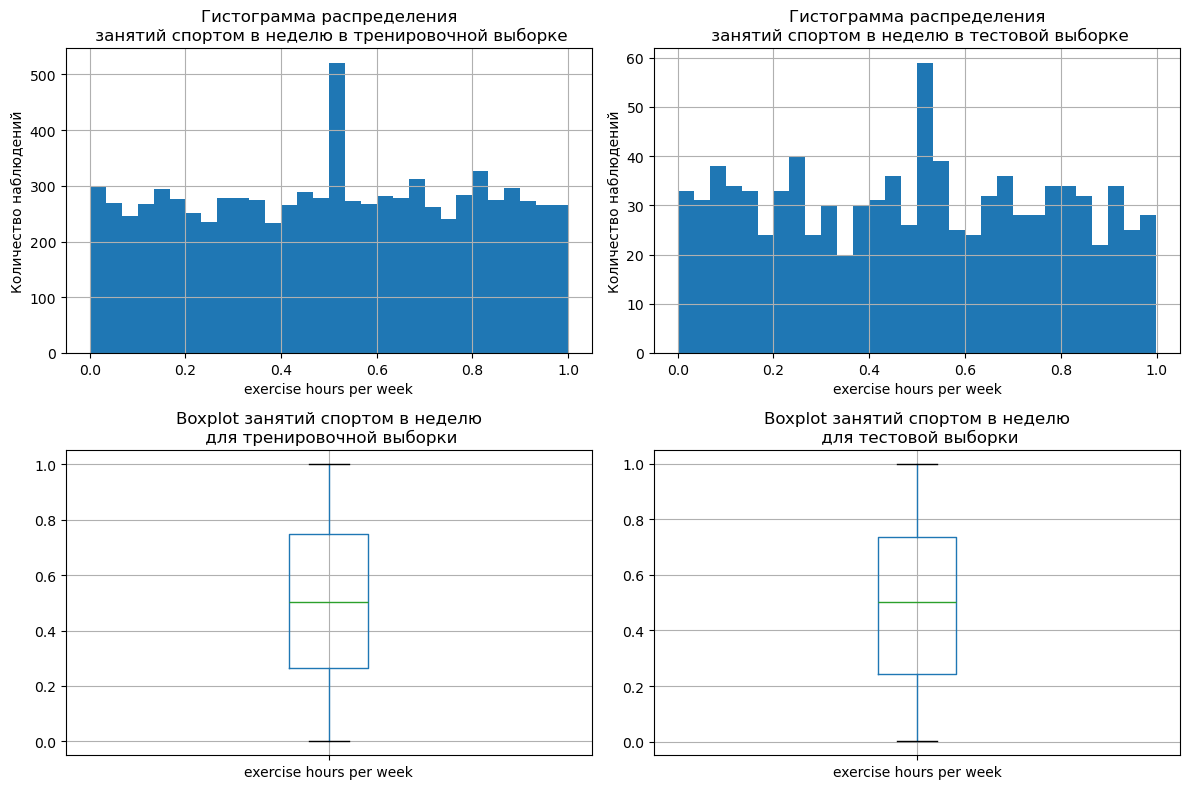

In [45]:
compare_quantity_analysis(heart_train, heart_test, 'exercise hours per week', 'занятий спортом в неделю')

In [46]:
borders(heart_train, 'exercise hours per week')

Размах "усов": 
1)нижняя граница: -0.464
2)верхняя граница: 1.4767
Межквартальный размах: 
1)нижняя граница: 0.2637642898778262
2)верхняя граница: 0.7489346644078112


Исходя из графика "Ящик с усами", данные в обоих датасетах сосредоточены в в одинаковых пределах. Выбросы отсутствуют, а также наблюдаются пики около 0.5. 

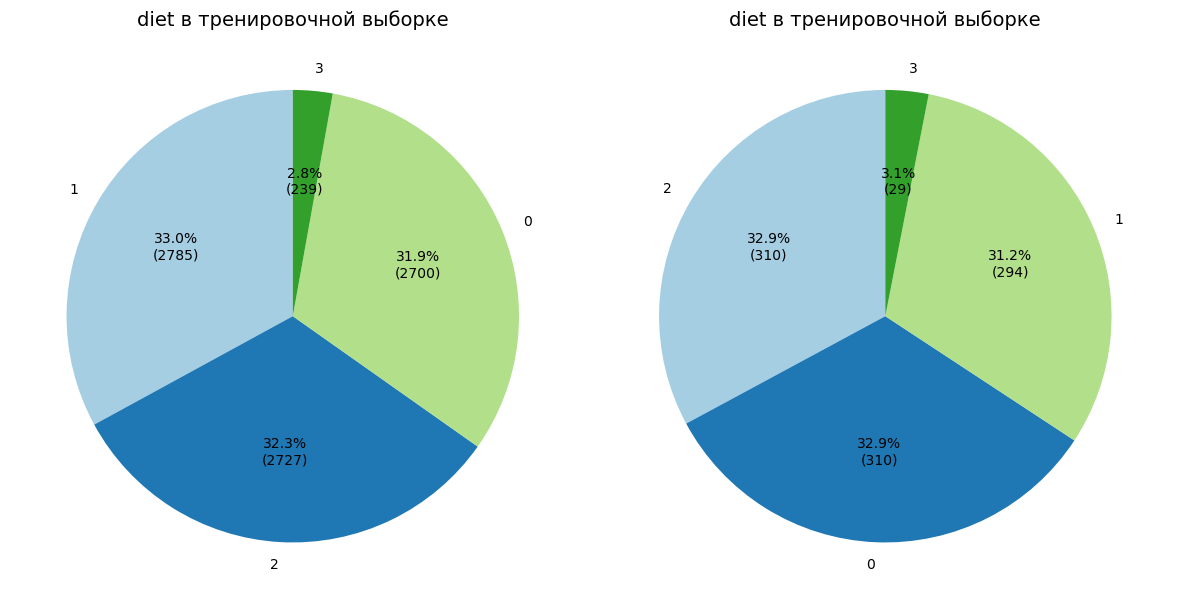

In [47]:
compare_cat_characteristics(heart_train, heart_test, 'diet')

Круговая демонстрирует, что данные в обоих датасетах имеют одинаковое распределение. В датасете представлено 4 вида диеты (плана питания), 3 вид представлен в наменьшей степени в обоих датасетах. 

Можно избавиться от него, чтобы модель луччше обучилась. То есть оставим только данные, где идентификатор диаеты не больше 2.

In [48]:
heart_train = heart_train[~(heart_train['diet']==3)]
heart_test = heart_test[~(heart_test['diet']==3)]

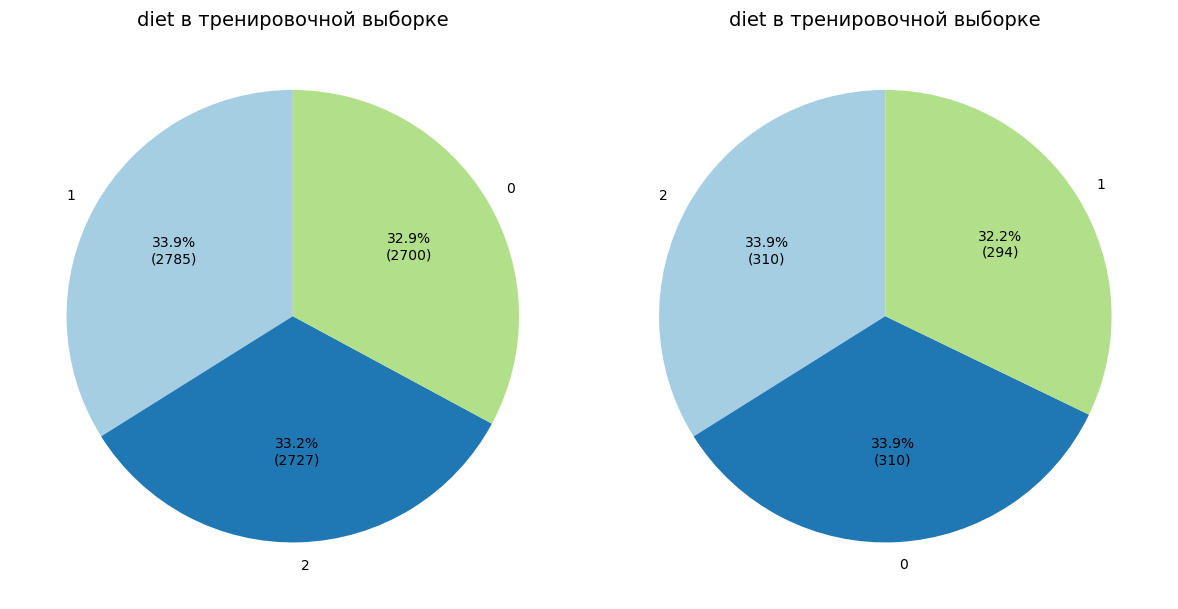

In [49]:
compare_cat_characteristics(heart_train, heart_test, 'diet')

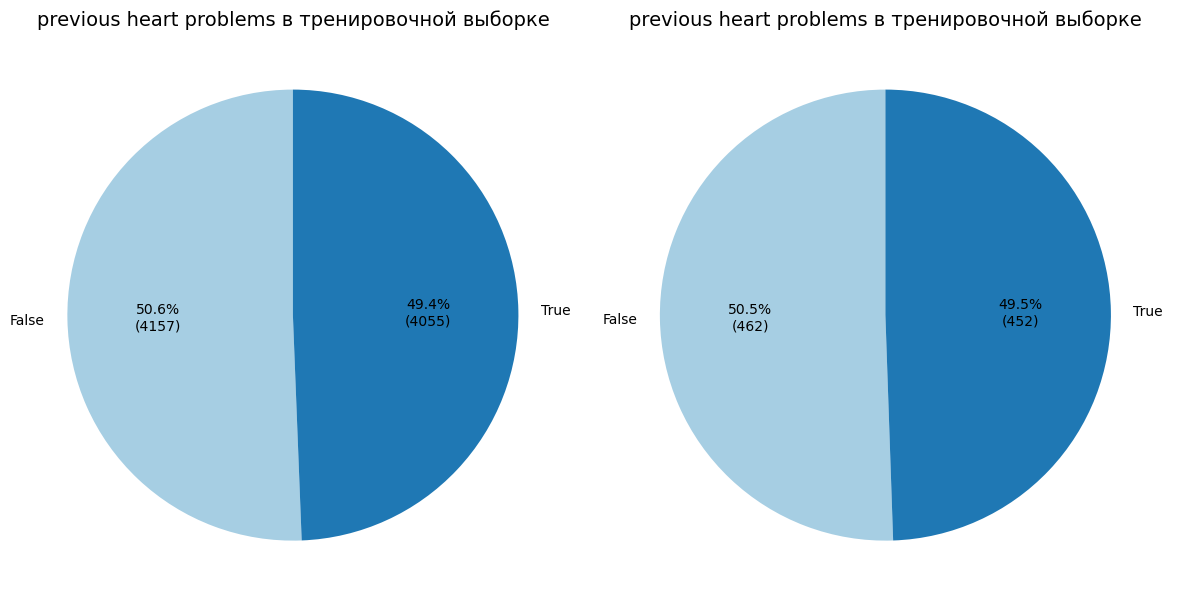

In [50]:
compare_cat_characteristics(heart_train, heart_test, 'previous heart problems')

`previous heart problems` является утечкой, так как исходя из здравого смысла, если у человека раньше были проблемы с сердцем, то более вероятно, что они будут и в будущем, поэтому данный признак будет ухудшать обучаемость, поэтому этот признак мы точно брать не будем и удалим прямо сейчас.

In [51]:
heart_train = heart_train.drop(columns='previous heart problems', axis=1)
heart_test = heart_test.drop(columns='previous heart problems', axis=1)

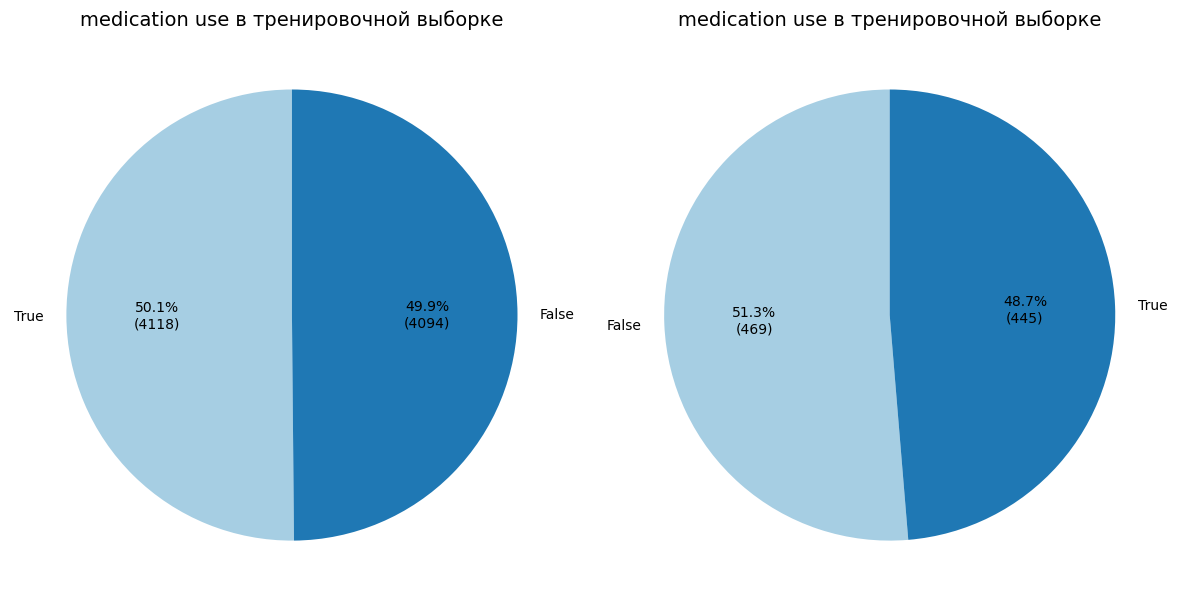

In [52]:
compare_cat_characteristics(heart_train, heart_test, 'medication use')

Не очень понятно, что значит прием препаратов. Как это соотносится с сердцем и риском сердечного приступа. Существует 2 варианты:

- Первый: данный признак является утечкой, так как если человек, например, уже пьет таблетки от сердца, то логично препдположить, что риск сердецчного приступа выше, чем у тех, кто их не принимает.

- Второй, менее вероятный, данная характеристика в целом указывает на то, что человек принимает какие-либо препараты.

Более логично, что это кардиопрепараты, следовательно данный признак автоматически можно считать утечкой.

In [53]:
heart_train = heart_train.drop(columns='medication use', axis=1)
heart_test = heart_test.drop(columns='medication use', axis=1)

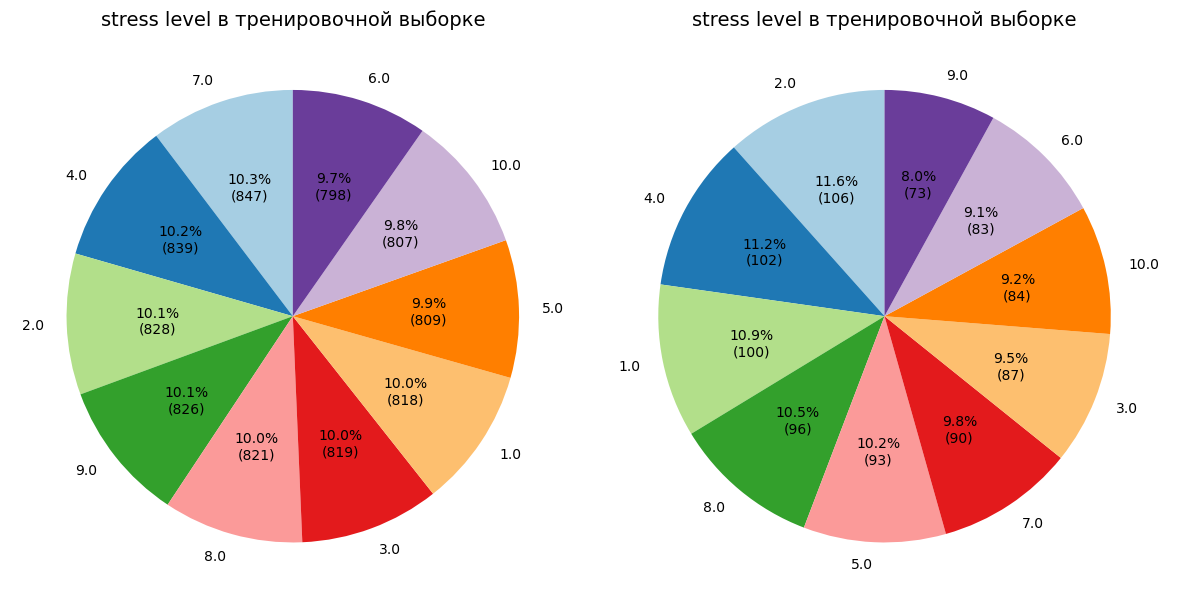

In [54]:
compare_cat_characteristics(heart_train, heart_test, 'stress level')

Круговая демонстрирует, что данные в обоих датасетах имеют одинаковое распределение. В датасете представлено 7 уровней стресса.

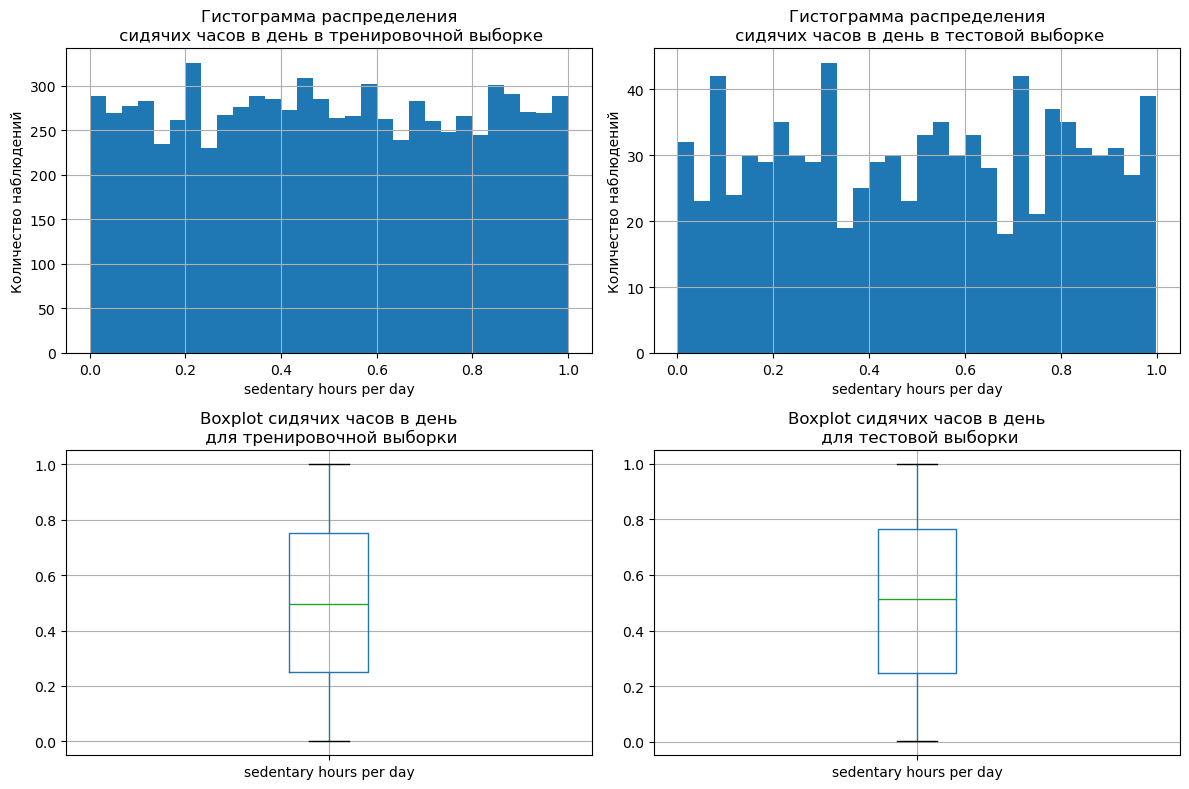

In [55]:
compare_quantity_analysis(heart_train,heart_test,\
                          'sedentary hours per day','сидячих часов в день')

In [56]:
heart_train['sedentary hours per day'].shape, heart_test['sedentary hours per day'].shape

((8212,), (914,))

`sedentary hours per day` - одинаково распределен в обоих датасетах (равномерное), просто из-за того, что кол-во данных в тренирвочной выборке в 8 раз меньше, а bins=30 как фиксированный параметр для данной функции, мы можем считать, что они распределены одинаково, несмотря на визуальные расхождения.

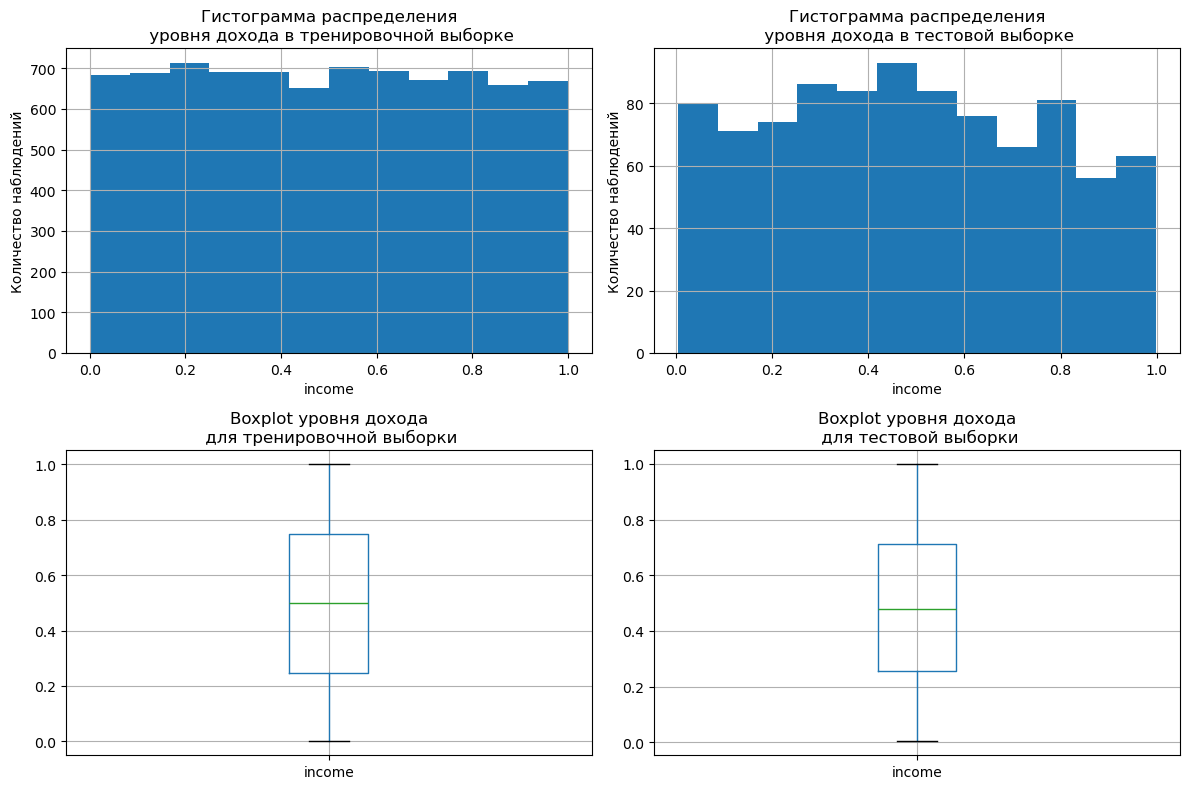

In [57]:
compare_quantity_analysis(heart_train,heart_test,\
                          'income','уровня дохода', bins=12)

`income` - уровень дохода почти одинаково распределен в обоих датасетах - равномерное. Выбросы отсутсвуют.

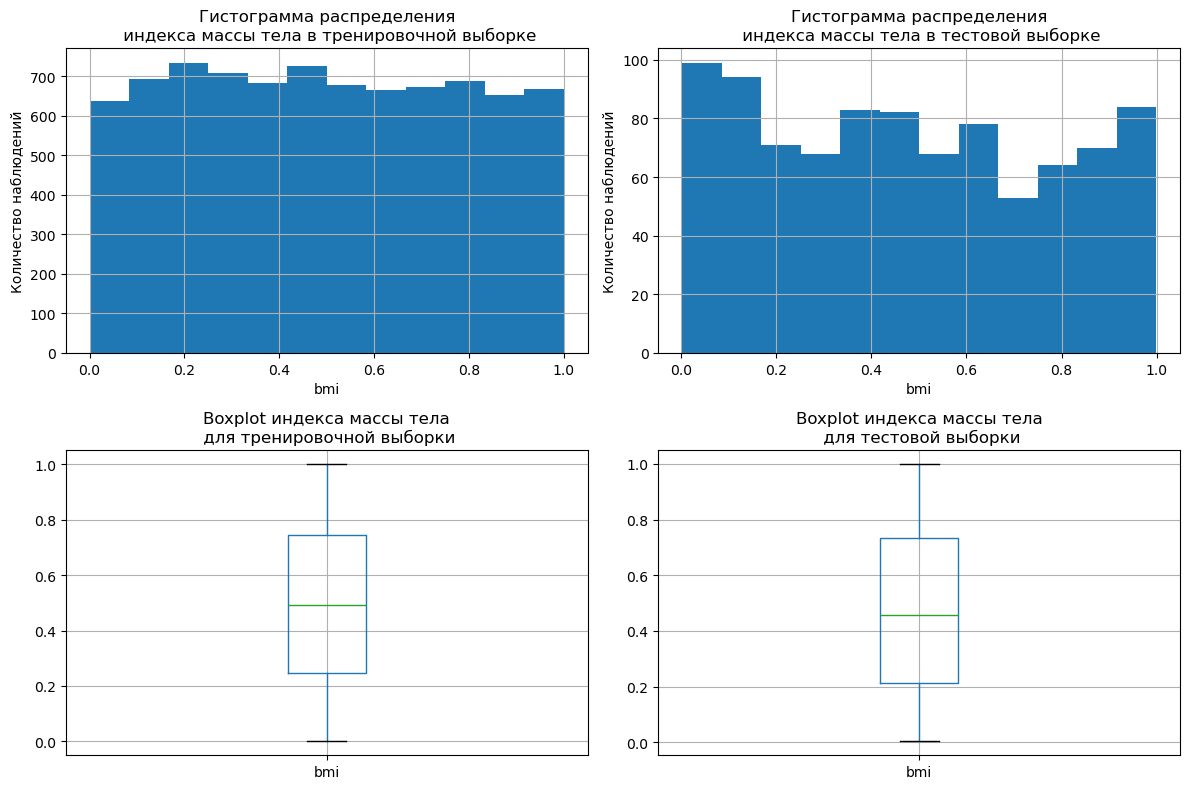

In [58]:
compare_quantity_analysis(heart_train,heart_test,\
                          'bmi','индекса массы тела', bins=12)

In [59]:
heart_train['bmi'].shape, heart_test['bmi'].shape

((8212,), (914,))

`bmi` - одинаково равномерно распределен в обоих датасетах, просто из-за того, что кол-во данных в тренирвочной выборке в 8 раз меньше, а bins=30 как фиксированный параметр для данной функции, мы можем считать, что они распределены одинаково, несмотря на визуальные расхождения.

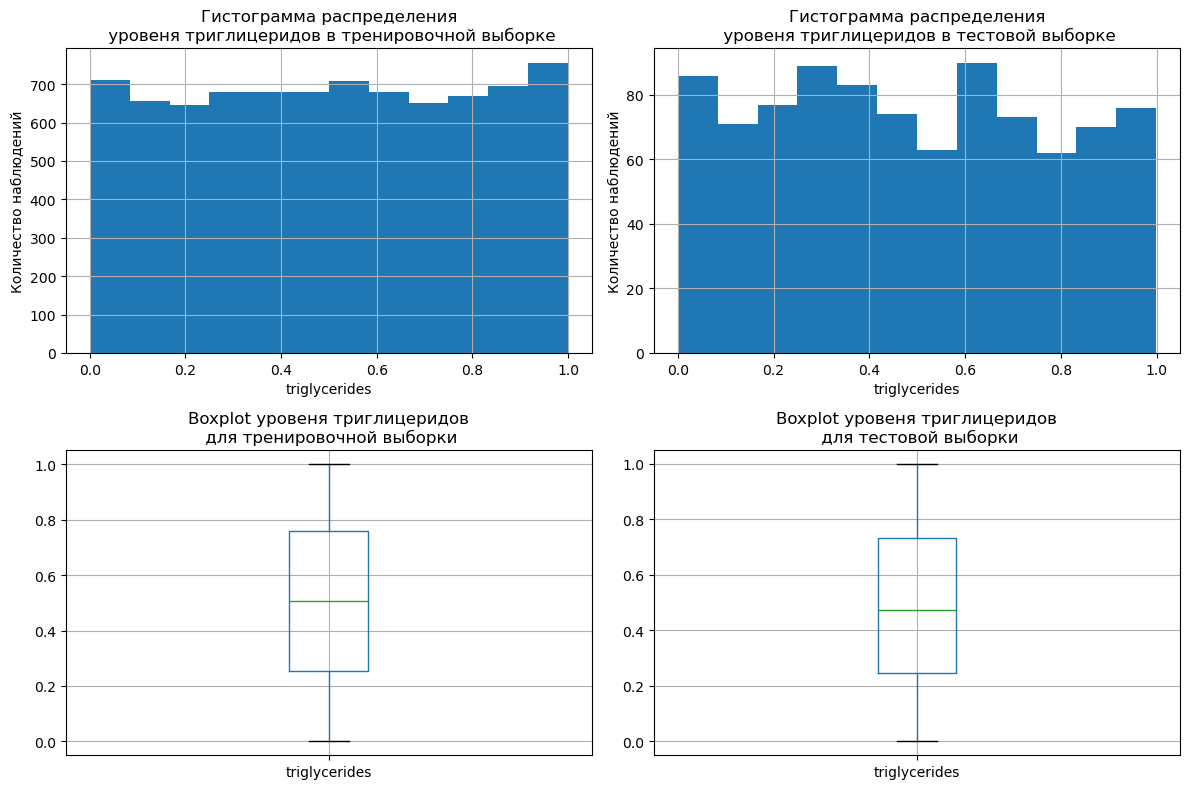

In [60]:
compare_quantity_analysis(heart_train,heart_test,\
                          'triglycerides','уровеня триглицеридов', bins=12)

`triglycerides` - уровень триглицеридов одинаково равномерно распределен в обоих датасетах.

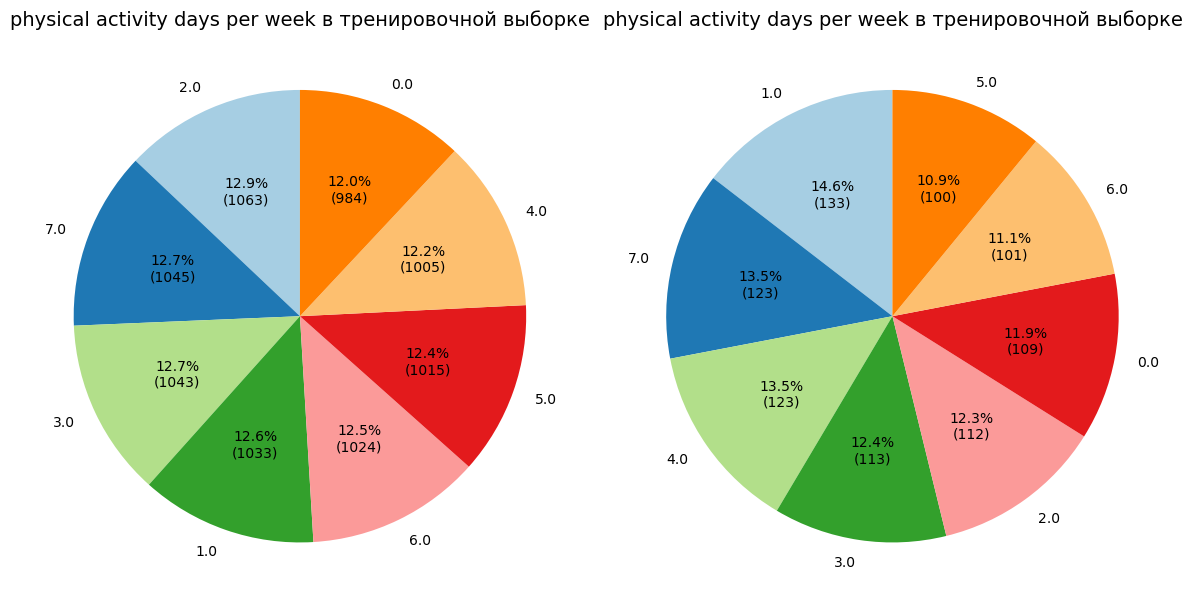

In [61]:
compare_cat_characteristics(heart_train, heart_test, 'physical activity days per week')

Круговая демонстрирует, что данные в обоих датасетах имеют одинаковое распределение. В датасете представлены одинаковые пропорции каждого вида "физ нагрузки", от 0 до 7 дней в неделю.

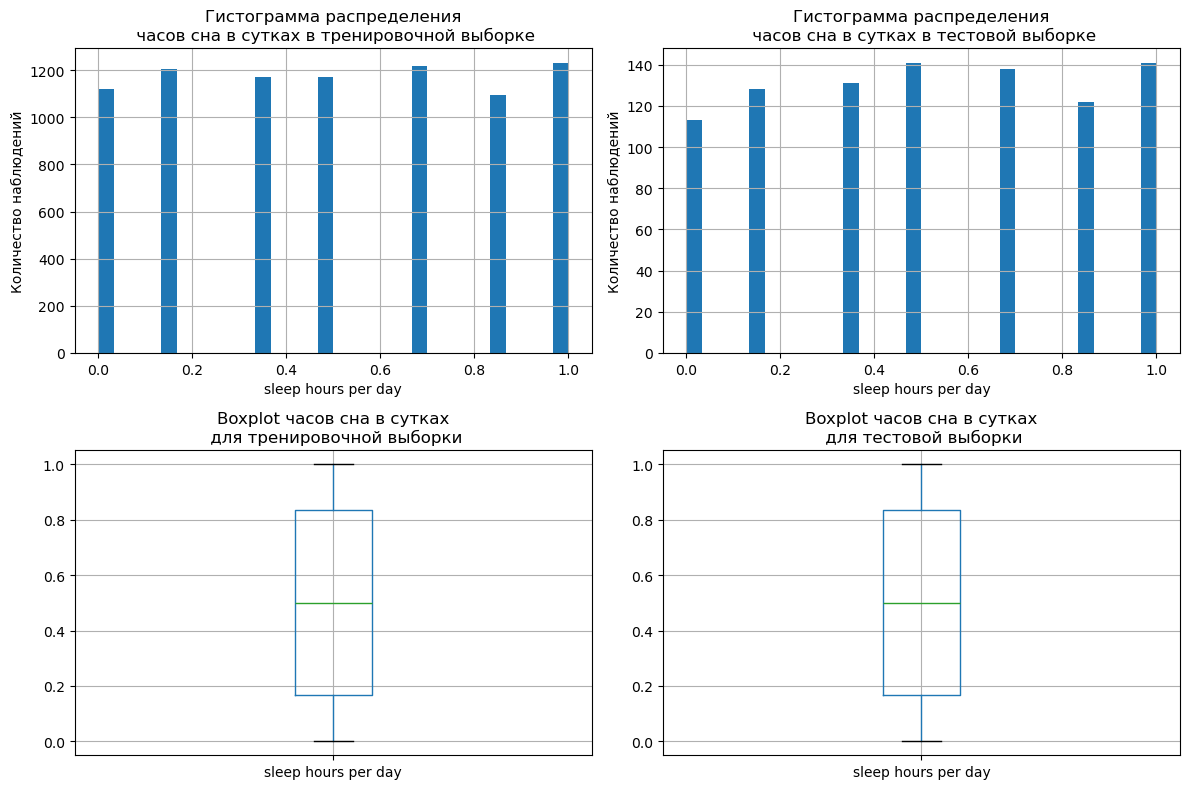

In [62]:
compare_quantity_analysis(heart_train,heart_test,\
                          'sleep hours per day','часов сна в сутках')

Исходя из реальной жизни, мы знаем, что в среднем люди спят по 7-8 часов, то есть скорее всего 0.5 соотвествует 7-8 часам, значит данные расположены в диапазоне от 30 минут до 15 часов. Возможно, что кто-то, у кого высокий уровень стресса и большая рабочая нагрузка, то их сон явно меньше 7-8 часов или же наоборот, недостаточное кол-во часов сна влияют на уровень стресса.

In [63]:
stats = heart_train.groupby('stress level')['sleep hours per day'].agg(['mean'])
stats

,mean
stress level,
1.0,0.520986
2.0,0.513889
3.0,0.493081
4.0,0.504569
5.0,0.494026
6.0,0.497911
7.0,0.507477
8.0,0.510353
9.0,0.482042


In [64]:
heart_train[['stress level','sleep hours per day']].corr()

,stress level,sleep hours per day
stress level,1.000000,-0.013228
sleep hours per day,-0.013228,1.000000


Исходя из стат расчетов, часы сна и уровень стресса никак не связаны, хотя научные статьи о влиянии сна на жизнь говорят об обратном.

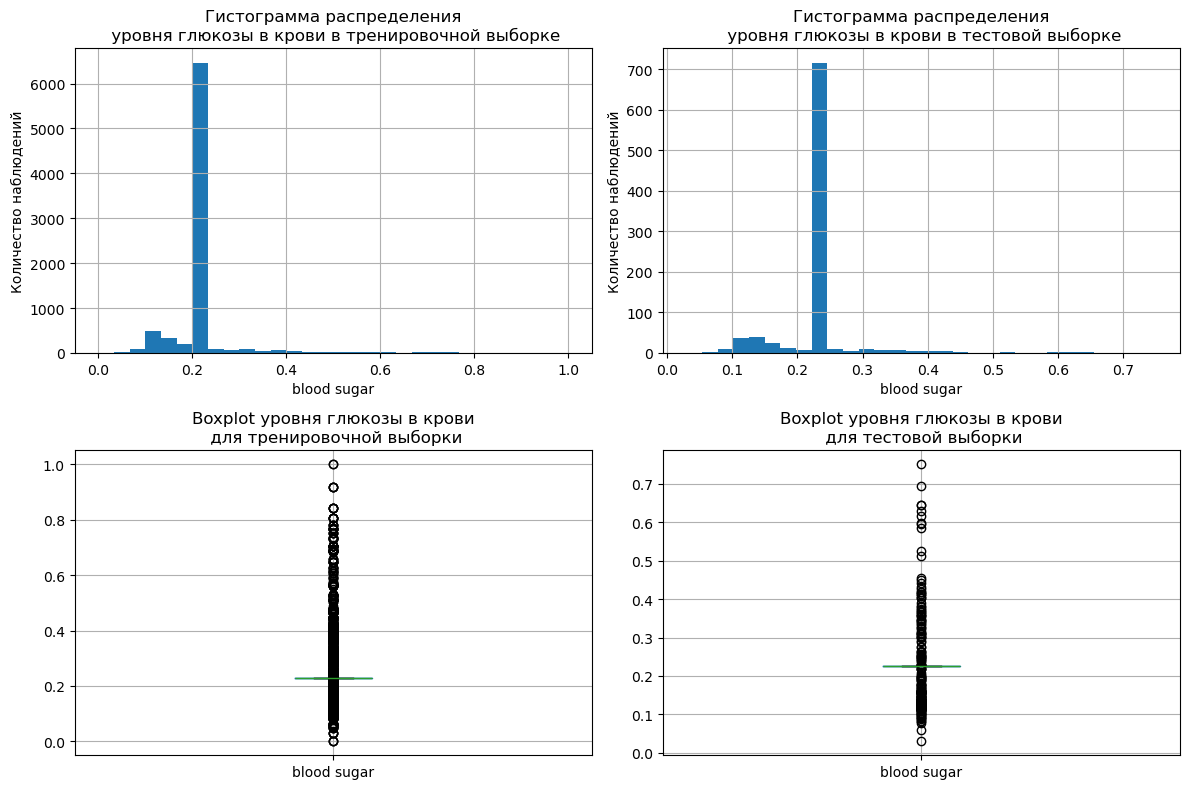

In [65]:
compare_quantity_analysis(heart_train,heart_test,\
                          'blood sugar','уровня глюкозы в крови')

In [66]:
borders(heart_train, 'blood sugar')

Размах "усов": 
1)нижняя граница: 0.227
2)верхняя граница: 0.227
Межквартальный размах: 
1)нижняя граница: 0.2270175751137986
2)верхняя граница: 0.2270175751137986


In [67]:
heart_train['blood sugar'].describe().T

count    8212.000000
mean        0.228022
std         0.075645
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: blood sugar, dtype: float64

In [68]:
heart_train[['blood sugar','diabetes']].corr()

,blood sugar,diabetes
blood sugar,1.00000,0.00343
diabetes,0.00343,1.00000


In [69]:
heart_train[['blood sugar','diabetes']].corr(method='spearman')

,blood sugar,diabetes
blood sugar,1.000000,0.000532
diabetes,0.000532,1.000000


Исходя из корреляции между диабетом и уровнем сахара в крови, мы видим, что уровень сахара в крови и наличие диабета никак не связаны,ни линейно в случае корреляции Пирсона, ни через монотонную функцию в случае корреляции Спирмена, что очень странно для реальной жизни, где зависимость прямая и сильная.


По данному анализу, в целом, определяют наличие диабета: *"Нормальным считается уровень сахара в крови натощак ниже 100 мг/дл (5,6 ммоль/л). Уровень сахара в крови натощак 126 мг/дл (7,0 ммоль/л) или выше соответствует диабетическому диапазону."* (сайт - https://www.diabinfo.de/ru/leben/diabet-2-go-tipa/osnovy/diagnostika.html#:~:text=Нормальным%20считается%20уровень%20сахара%20в,или%20выше%20соответствует%20диабетическому%20диапазону.)

Теперь посмотрим на то, сколько собой представляют выбросы, которые выходят за: 

*Размах "усов":*

1)нижняя граница: 0.227

2)верхняя граница: 0.227

*Межквартальный размах:* 

1)нижняя граница: 0.2270175751137986

2)верхняя граница: 0.2270175751137986

In [70]:
portion_train = heart_train[(heart_train['blood sugar'] > 0.3)|(heart_train['blood sugar'] < 0.1)].shape[0] / heart_train.shape[0] * 100
portion_test = heart_test[(heart_test['blood sugar'] > 0.3)|(heart_test['blood sugar'] < 0.1)].shape[0] / heart_test.shape[0] * 100
print(f'Доля данных в тренировочной выборке, где уровень сахара 0.3 и меньше 0.1: {portion_train:.2f}%')
print(f'Доля данных в тестовой выборке, где уровень сахара 0.3 и меньше 0.1: {portion_test:.2f}%')

Доля данных в тренировочной выборке, где уровень сахара 0.3 и меньше 0.1: 6.90%
Доля данных в тестовой выборке, где уровень сахара 0.3 и меньше 0.1: 6.89%


In [71]:
(row_train - heart_train.shape[0])/row_train*100, (row_test - heart_test.shape[0])/row_test*100

(5.446171560161198, 5.383022774327122)

Было удалено достаточное кол-во данных, если мы сейчас избавимся еще от 6.90% и 6.89% соотвественно, это может очень сильно повлиять на объем и полноту выборки.

Скорее всего, мы оставим признак либо "diabetes", либо "blood sugar", что будет больше коррелировать с целевым признаком.


In [72]:
heart_train[['blood sugar','diabetes','heart attack risk (binary)']].corr(method='spearman')

,blood sugar,diabetes,heart attack risk (binary)
blood sugar,1.000000,0.000532,0.010360
diabetes,0.000532,1.000000,0.016767
heart attack risk (binary),0.010360,0.016767,1.000000


Так как "diabetes" имеет большую корреляцию с целевым признаком, то удалим `blood sugar`

In [73]:
heart_train = heart_train.drop(columns='blood sugar', axis=1)
heart_test = heart_test.drop(columns='blood sugar', axis=1)

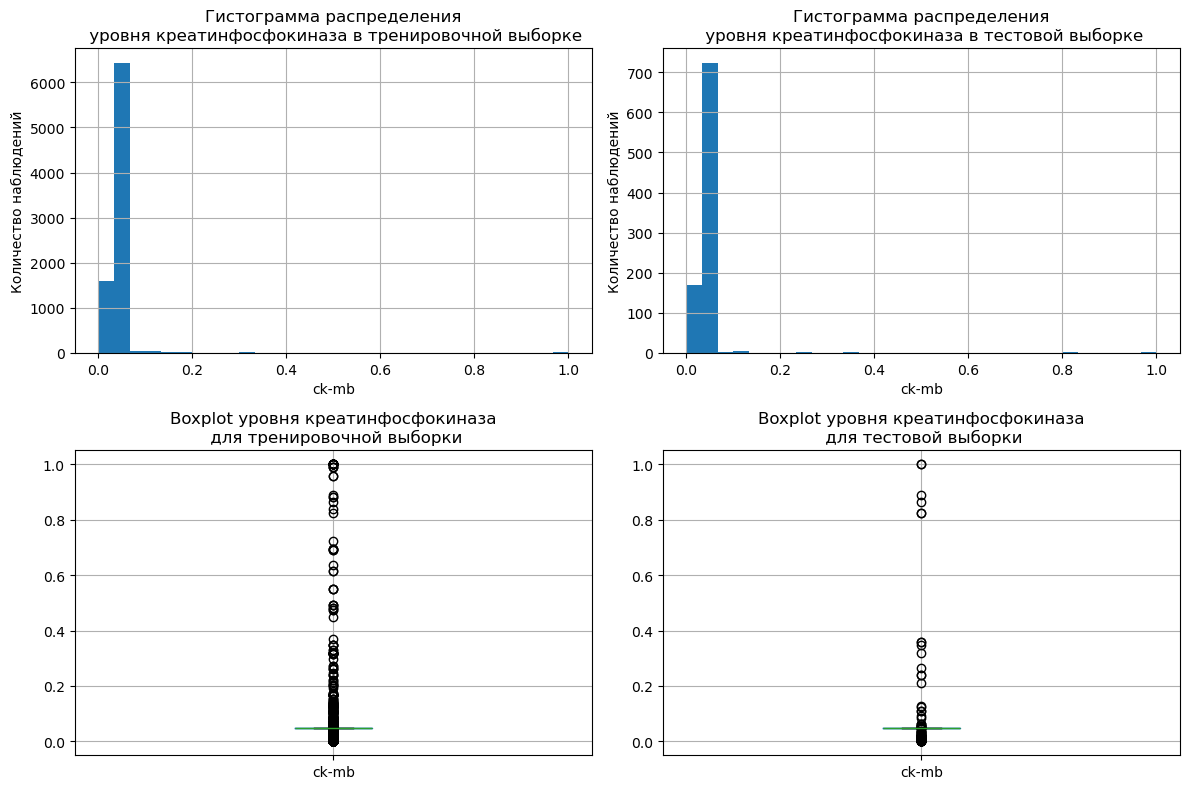

In [74]:
compare_quantity_analysis(heart_train,heart_test,\
                          'ck-mb','уровня креатинфосфокиназа')

Ситуация, аналогичная уровню сахара в крови, посмотрим какой объем данных приходится на данные пропуски.

In [75]:
portion_train = heart_train[(heart_train['ck-mb'] > 0.1)].shape[0] / heart_train.shape[0] * 100
portion_test = heart_test[(heart_test['ck-mb'] > 0.1)].shape[0] / heart_test.shape[0] * 100
print(f'Доля данных в тренировочной выборке, где уровень креатинфосфокиназа больше 0.2: {portion_train:.2f}%')
print(f'Доля данных в тестовой выборке, где уровень креатинфосфокиназа больше 0.2: {portion_test:.2f}%')

Доля данных в тренировочной выборке, где уровень креатинфосфокиназа больше 0.2: 1.89%
Доля данных в тестовой выборке, где уровень креатинфосфокиназа больше 0.2: 1.97%


In [76]:
heart_train[['ck-mb','heart attack risk (binary)']].corr(method='spearman')

,ck-mb,heart attack risk (binary)
ck-mb,1.000000,0.015494
heart attack risk (binary),0.015494,1.000000


В целом, какой-то даже слабой корреляции не наблюдается, поэтому можно в целом не включать данный признак при обучении модели.

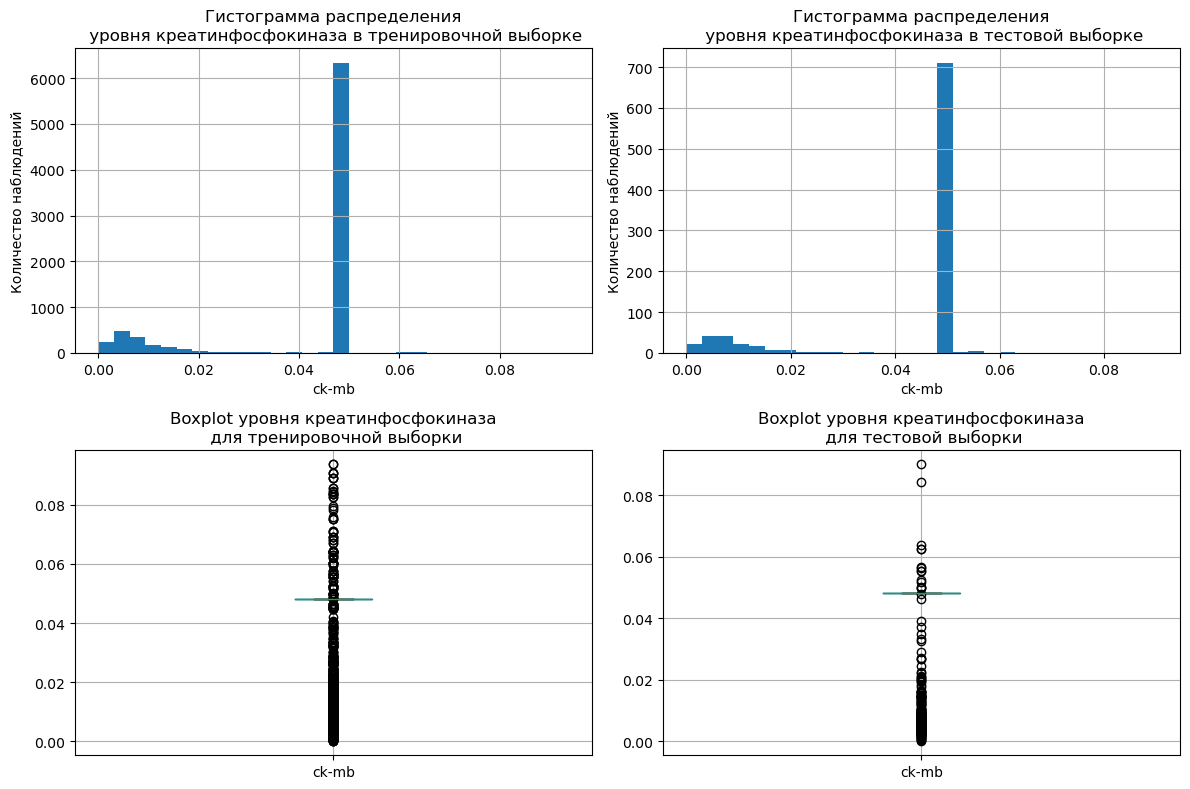

In [77]:
compare_quantity_analysis(heart_train[heart_train['ck-mb']<=0.1],heart_test[heart_test['ck-mb']<=0.1],\
                          'ck-mb','уровня креатинфосфокиназа')

Пока оставим признак, так как его корреляция с целевым находится почти на одном уровне с признаком "наличие/отсутвие диабета". Удаление данных, где уровень креатинфосфокиназа выше 0.1 не позволяет избавиться от выбросов полностью, поэтому не будет сокращать объем данных. 

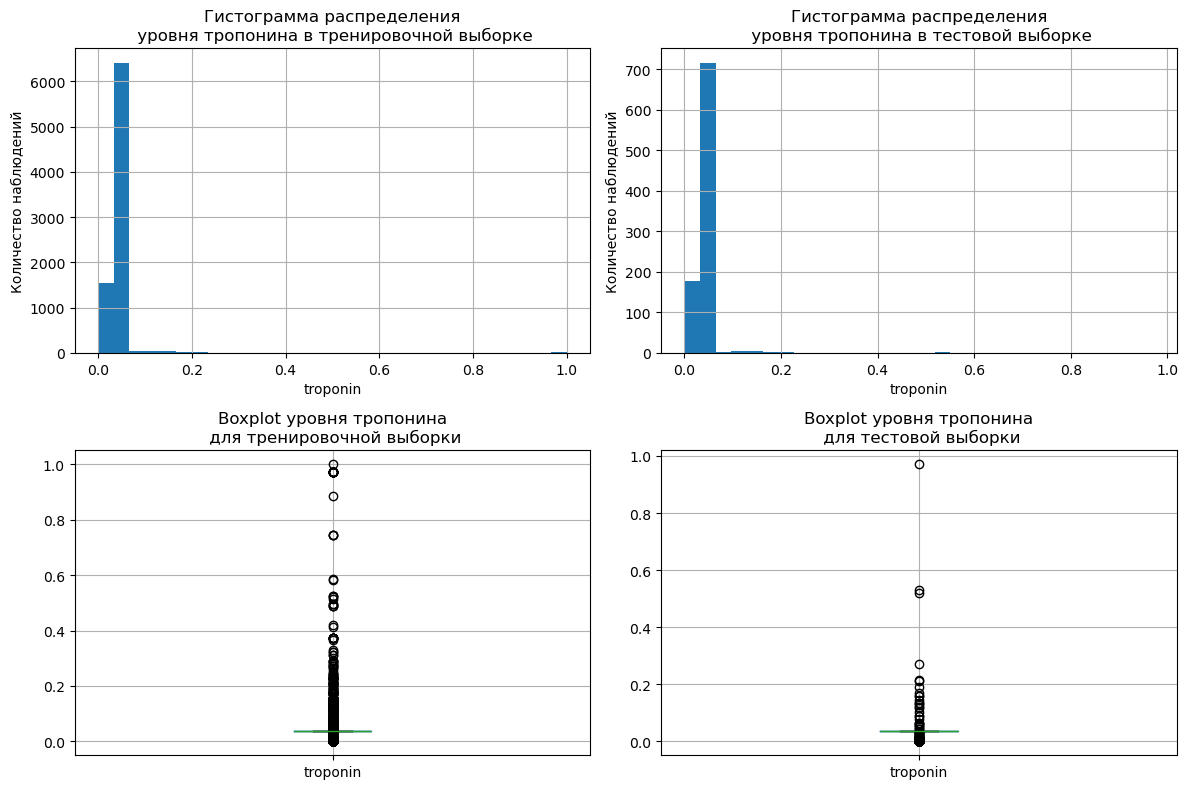

In [78]:
compare_quantity_analysis(heart_train,heart_test,\
                          'troponin','уровня тропонина')

In [79]:
heart_train['troponin'].describe().T

count    8212.000000
mean        0.036852
std         0.060030
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: troponin, dtype: float64

Аналогичная ситуация, почти все значения состредоточены вокруг 0.036512, а все остальные выступают как выбросы. 

In [80]:
heart_train[['troponin','heart attack risk (binary)']].corr(method='spearman')

,troponin,heart attack risk (binary)
troponin,1.000000,0.013533
heart attack risk (binary),0.013533,1.000000


Как видно, не наблюдается даже слабой зависимости при расмотрении корреляции Спирмена. Не будем сокращать объем выборки и оставим все без изменений. 



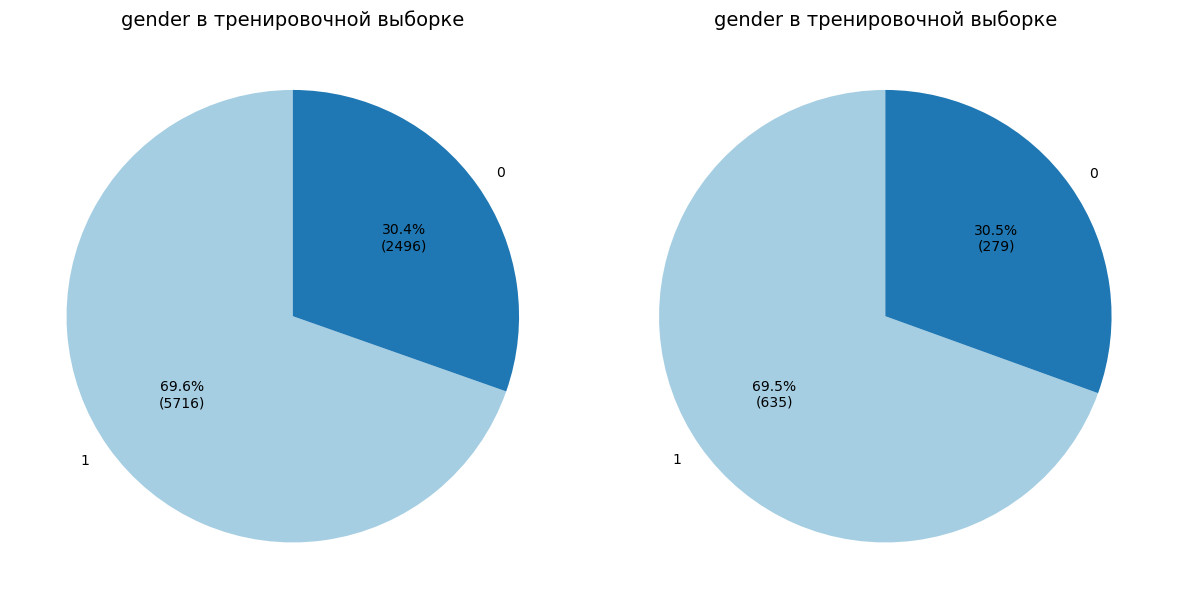

In [81]:
compare_cat_characteristics(heart_train, heart_test, 'gender')

В обоих выборках наблюдается явный дизбаланс классов, мужчин в обоих датасетах на порядок выше, здесь скорее всего придется прибегать к инстурментам сэмплирования признаков.

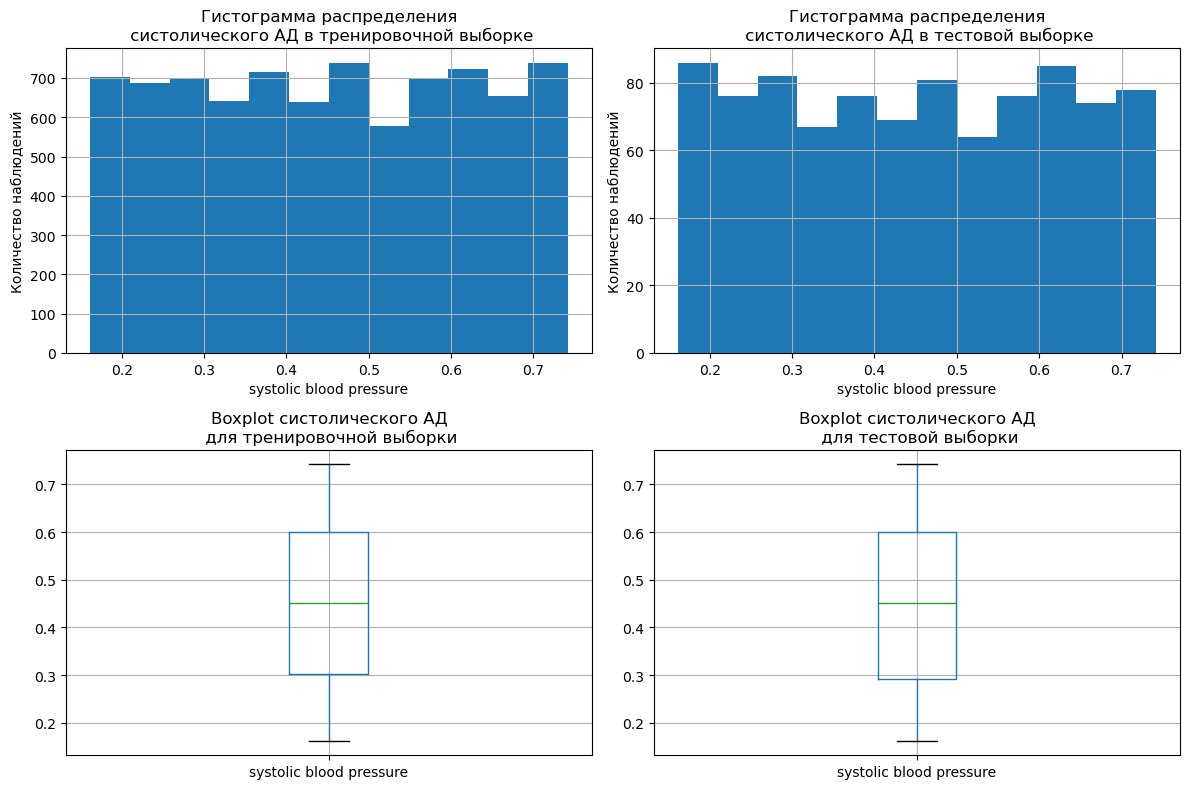

In [82]:
compare_quantity_analysis(heart_train,heart_test,\
                          'systolic blood pressure','систолического АД', bins=12)

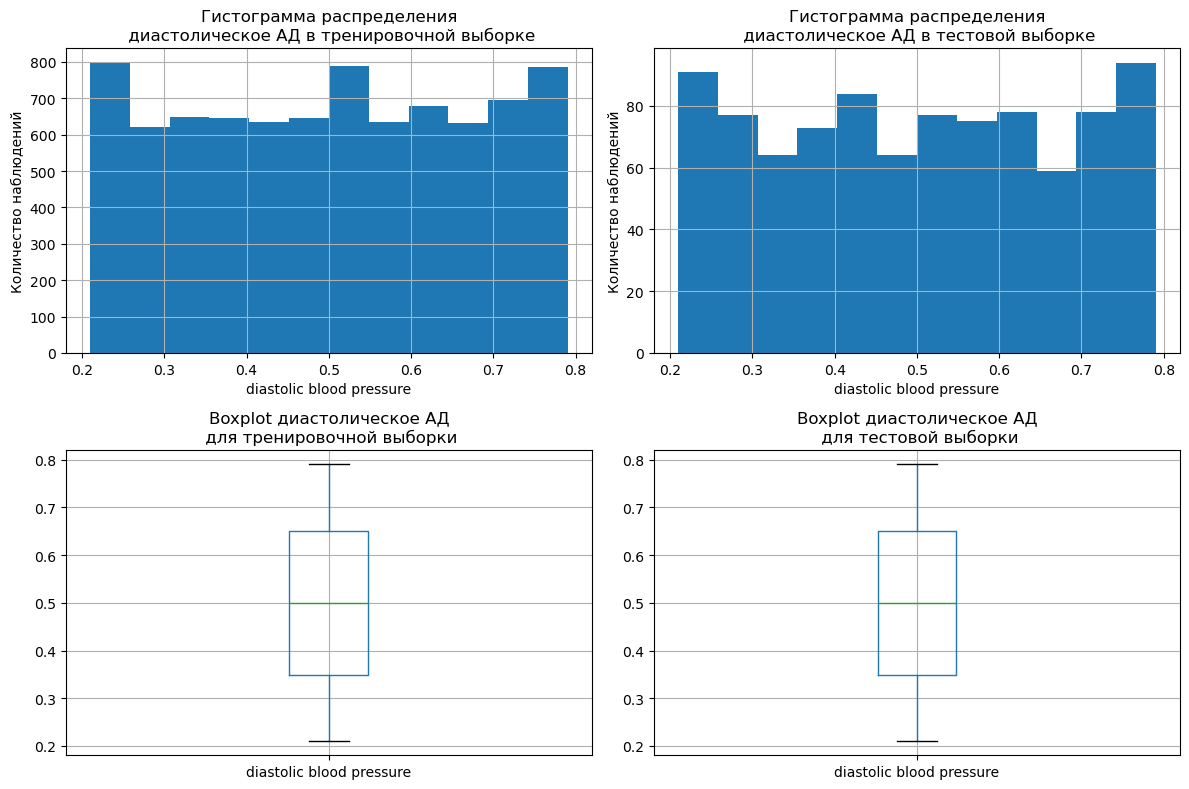

In [83]:
compare_quantity_analysis(heart_train,heart_test,\
                          'diastolic blood pressure','диастолическое АД', bins=12)

Что касается давления, то оба и систолическое, и  диастолическое имеют равномерное распределение, как в тренировочном, так и в тестовом датасете.

Рассмотрим теперь распределение целевого признака, который представлен только в тренировочном датасете.

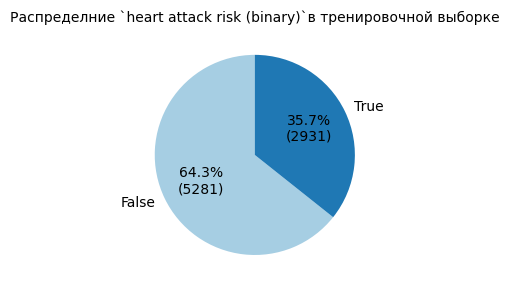

In [84]:

counts = heart_train['heart attack risk (binary)'].value_counts()

def func(pct, allvals):
    absolute = round(pct / 100. * np.sum(allvals))
    return f"{pct:.1f}%\n({absolute})"


fig, axes = plt.subplots(1, 1, figsize=(3,3))


axes.pie(counts, labels=counts.index, autopct=lambda pct: func(pct, counts),
            startangle=90, colors=plt.cm.Paired.colors)
axes.set_title(f'Распределние `heart attack risk (binary)`в тренировочной выборке', fontsize=10)

plt.tight_layout()
plt.show()

Как видно, признак "отсуствие риска сердечного приступа" чаще представлен в тренировочной выборке, 64,3% против 35,7%. Проблему дизбаланса будет решать в рамках пайплайна.

**Построим корреляционные метрицы для тренировочной и тестовой выборок, чтобы отобрать те признаки, которые будут использованы в данных для моделирования.**

**Для того, чтобы охарактеризовать корреляцию между признаками, воспользуемся шкалой Чеддока.**

**Шкала Чеддока**

| Теснота связи     | Значение коэффициента корреляции при наличии прямой связи | Значение коэффициента корреляции при наличии обратной связи |
|-------------------|-----------------------------------------------------------|-------------------------------------------------------------|
| **Слабая**        | 0.1 – 0.3                                                | (−0.1) – (−0.3)                                            |
| **Умеренная**     | 0.3 – 0.5                                                | (−0.3) – (−0.5)                                           |
| **Заметная**      | 0.5 – 0.7                                                | (−0.5) – (−0.7)                                           |
| **Высокая**       | 0.7 – 0.9                                                | (−0.7) – (−0.9)                                           |
| **Весьма высокая**| 0.9 – 1                                                  | (−0.9) – (−1)                                            |

**Поскольку целевым признаком в дальнейшем моделировании будет «heart attack risk (binary)», целесообразно сначала исследовать, как данный показатель коррелирует с остальными количественными/категориальными переменными.** Это поможет понять, какие из признаков вносят наиболее весомый вклад в объяснение уровня удовлетворенности.

Воспользуемся `phik_matrix`, чтобы посмотреть на общую картину взаимосвязей признаков в тренировочном датасете. 

Напишем сразу функцию, чтобы в будущем было проще сразу строить корреляцию целевого и остальных. 

In [85]:
def corr_target_vs_all(feature, df):
    matrix = df.phik_matrix(
    interval_cols=['age', 'cholesterol', 'heart rate','exercise hours per week',\
        'sedentary hours per day', 'income', 'bmi','triglycerides','sleep hours per day',\
            'ck-mb','troponin','systolic blood pressure','diastolic blood pressure']).round(3)

    # Формируем новый порядок: сначала нужный признак, затем все остальные
    ordered_features = [feature] + [col for col in matrix.columns if col != feature]
    
    print(f'Корреляция {feature} с другими признаками')

    return matrix.reindex(index=ordered_features, columns=ordered_features)

In [86]:
def assign_chedock_group(corr_matrix):

    results = []
    first_col = corr_matrix.columns[0]
    
    for feature in corr_matrix.index:
        corr_value = corr_matrix.loc[feature, first_col]
        
        if corr_value < 0.1:
            group = "Отсутствует/Незначимая"
        elif 0.1 <= corr_value < 0.3:
            group = "Слабая"
        elif 0.3 <= corr_value < 0.5:
            group = "Умеренная"
        elif 0.5 <= corr_value < 0.7:
            group = "Заметная"
        elif 0.7 <= corr_value < 0.9:
            group = "Высокая"
        elif 0.9 <= corr_value <= 1:
            group = "Весьма высокая"
        else:
            group = "Не определена"
            
        results.append({
            "Признак": feature,
            "Коэффициент": round(corr_value, 3),
            "Группа связи": group
        })
    
    result_df = pd.DataFrame(results)
    return result_df

In [87]:
feature = 'heart attack risk (binary)'
assign_chedock_group(corr_target_vs_all(feature,heart_train)).sort_values(by='Группа связи')

Корреляция heart attack risk (binary) с другими признаками


,Признак,Коэффициент,Группа связи
0,heart attack risk (binary),1.000,Весьма высокая
20,gender,0.000,Отсутствует/Незначимая
19,troponin,0.027,Отсутствует/Незначимая
18,ck-mb,0.000,Отсутствует/Незначимая
17,sleep hours per day,0.000,Отсутствует/Незначимая
16,physical activity days per week,0.009,Отсутствует/Незначимая
15,triglycerides,0.000,Отсутствует/Незначимая
14,bmi,0.000,Отсутствует/Незначимая
13,income,0.000,Отсутствует/Незначимая
12,sedentary hours per day,0.024,Отсутствует/Незначимая


Исходя из шкалы Чеддока, ни один из признаков не имеет даже слабой корреляции с целевым признаком. В данной ситуации стоит выбирать те признака, которые имеют корреляцию выше 0, то есть для обучения будем брать признаки, которые чисто из здравого смысла будут влиять на целевой.

**Рассмотрим корреляцию между признаками, чтобы обнаружить мультиколлинеарность и устранить ее в случае обнаружения.** 

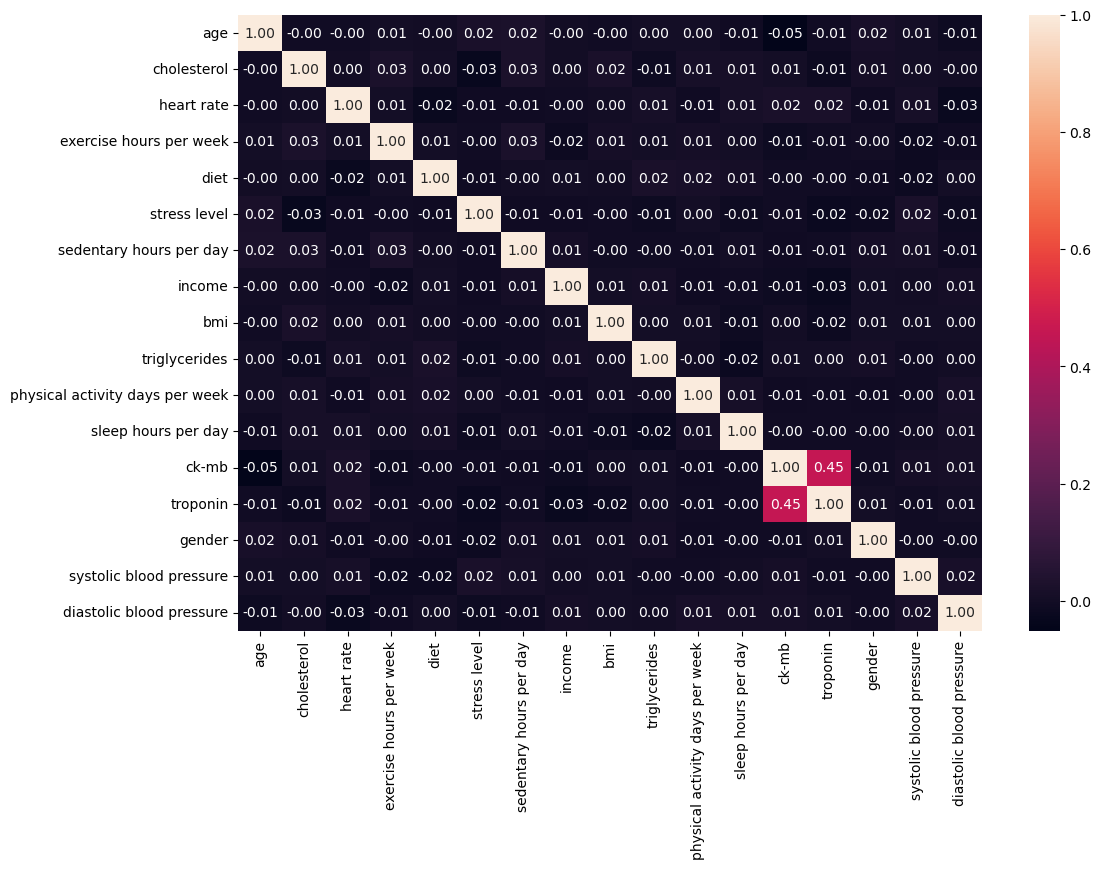

In [88]:
plt.figure(figsize=(12, 8))  
sns.heatmap(heart_train.select_dtypes(include='number').corr(method='spearman'), annot=True, fmt='.2f'); 
plt.show()

Исходя из матрицы корреляций, не наблюдается корреляция между признаками, что странно, так как некотрые признаки обязаны коррелировать между собой, например, heart rate и age, что доказывается не только медицинскими исследованиями, но и статистикой. Для отбора признаком будем эксперементировать с признаками и гиперпараметрами, чтобы получтить модель лучше, чем дала бы Dummy Clasifier.

Теперь построим матрицу корреляций `phik` и сравним полученные результаты с матрицей корреляций по Спирмену.

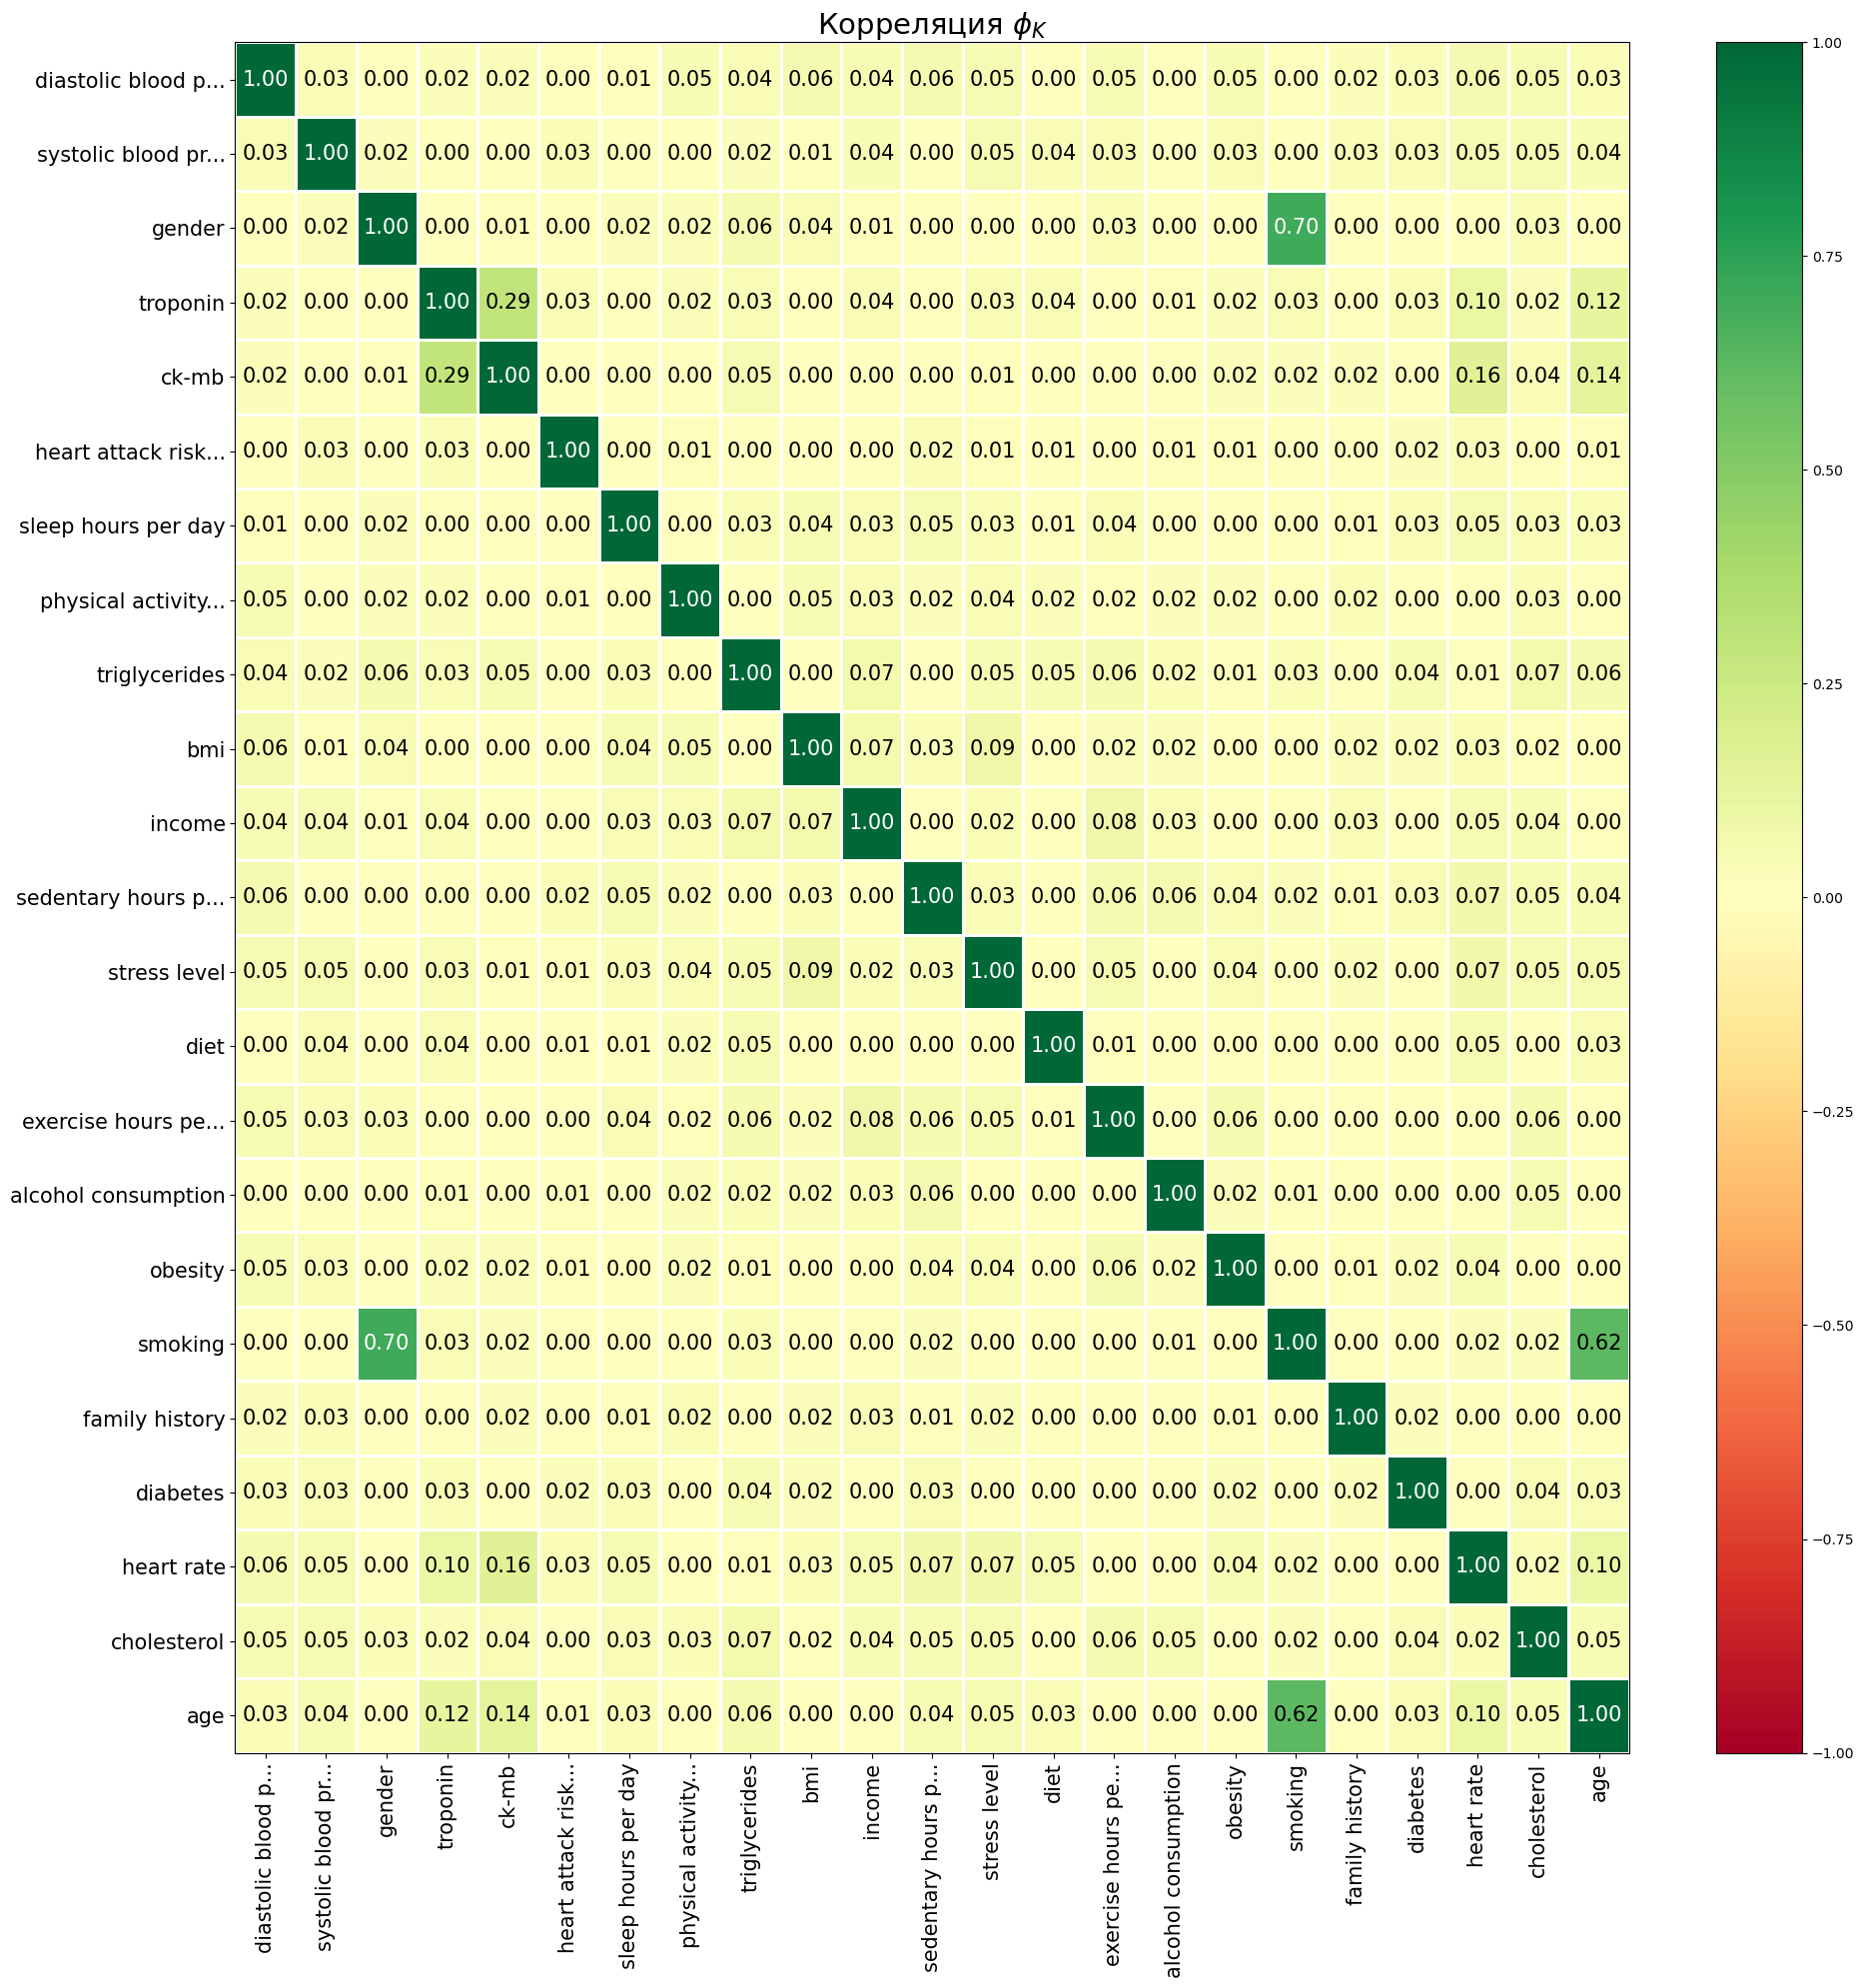

In [89]:
# список интервальных признаков
interval_cols = ['age', 'cholesterol', 'heart rate','exercise hours per week',\
        'sedentary hours per day', 'income', 'bmi','triglycerides','sleep hours per day',\
            'ck-mb','troponin','systolic blood pressure','diastolic blood pressure']

# вычисление коэффициентов корреляции phi для датафрейма 
phik_overview = heart_train.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Корреляция $\phi_K$",
    fontsize_factor=1.5,
    figsize=(20, 20)
)

**зависимости `phik_matrix`**

(Phik) ∈ \[0 ; 1] оценивает *любую* (не только линейную) связь между переменными. Ниже выделены только значения ≥ 0.25 (убедительные) и 0.10 – 0.25 (слабые, но потенциально важные).

| Сильная связь        | φ<sub>k</sub> | Интерпретация и вывод                                                                                                                                                                                                                   |
| -------------------- | ------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **gender ↔ smoking** | **0.70**      | В выборке мужчины курят существенно чаще, чем женщины. Признак `smoking` частично дублирует информацию о поле ⇒ возможна модель может ошибочно “научиться”, что пол = мужчина → риск, если не контролировать `smoking`, то есть для модели лучше оставить  |
| **age ↔ smoking**    | **0.62**      | Курение коррелирует с возрастом, что логично, так как дети, например, вряд ли употребляют никотин или же спиртное. При построении модели возраст и курение нужно будет найти баланс между этими признаками или вовсе избавиться от одного из них.                                                                                                     |
| **CK-MB ↔ troponin** | **0.29**      | Оба – кардиоспецифические ферменты, естественная биохимическая корреляция. Для модели может хватить одного из них, иначе рискуем мультиколлинеарностью.                                                                                 |
---

| Умеренная / слабая связь                          | φ<sub>k</sub>                                              | Интерпретация                                                                                                                          |
| ------------------------------------------------- | ---------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **heart rate ↔ CK-MB**                            | 0.16                                                       | Повышенный пульс часто сопровождает миокардиальный стресс. Логично, но сила связи всё ещё низкая.                    |
| **age ↔ CK-MB** (0.14), **age ↔ troponin** (0.12) | |                           Возраст слегка влияет на уровень troponin и CK-MB                                                                                                      |
| **stress level ↔ BMI**                            | 0.09                                                       | Наблюдается едва заметная (φ≈0.087) связь: при лишнем весе уровень стресса чуть выше.                                                |
| **exercise hours ↔ income**                       | 0.08                                                       | Уровень дохода оказывает влияние на кол-во проведенных часов в спортзале (физ нагрузки) |
| **blood pressure systolic ↔ diastolic**           | 0.03–0.05                                                  | Неожиданно малая корреляция — возможно, давление было дискретизировано или округлено. |

#### Связь с целевым признаком `heart attack risk (binary)`

| Переменная  | φ<sub>k</sub> с target | Оценка важности                                                                        |
| ----------- | ---------------------- | -------------------------------------------------------------------------------------- |
| heart rate  | **0.030**              | Самая “высокая” из обнаруженных, но по шкале Чеддока это всё ещё *очень слабая* связь. |
| systolic BP | 0.031                  | аналогично                                                                                      |
| troponin    | 0.027                  | аналогично                                                                                      |
| diabetes    | 0.019                  |аналогично                                                                                      |
| Остальные   | ≤ 0.013                | Практически нулевая корреляция.                                                        |

➡️ **Промежуточный вывод**: φ<sub>k</sub> не выявил явных факторов риска сердечного приступа, что ожидаемо — сердечный приступ обусловлен *комбинацией* факторов. Значит, модели, которые умеют ловить нелинейные и многомерные зависимости (GBM, XGBoost, CatBoost, RF, нейросети), окажутся более продуктивными, чем, например, простая логистическая регрессия.

Для дальнешего построения модели следует поработать с получившимися зависимостями.

   * Пары `CK-MB / troponin`, `gender / smoking`, `age / smoking` при необходимости оставить один признак или создать составной с помощью polyfeatures.
   * Добавить взаимодействия `age*smoking`, `gender*smoking`, `age*CK-MB`, раз признаки по отдельности слабы, но связаны.

**Промежуточные выводы по исследователному аналимзу данных:**

1. Структура и полнота выборок

* **Возраст**: обе выборки содержат три чётко выраженные когорты — дети, взрослые, пожилые. Перекосов нет, следовательно, возраст как признак обладает высокой полнотой.
* **Пол**: одинаковое распределение в train / test, однако присутствует дисбаланс — мужчин заметно больше.
* **Категориальные признаки** (`diet`, `physical activity`, `stress level` и др.) — пропорции совпадают в обеих выборках; лишь «диета 3» представлена слабо

2. Показатели анализа крови

| Признак                                   | Распределение                   | Выбросы                    | Комментарий                                                                                  |
| ----------------------------------------- | ------------------------------- | -------------------------- | -------------------------------------------------------------------------------------------- |
| **Холестерин**                            | Равномерный, три пика (возраст) | нет                        | Значения укладываются в клинические нормы, даже при том, что данные отмасштабированы.                                |
| **Триглицериды, BMI, сердц. ритм**        | ≈ равномерные                   | единичные <br> (удалены)   | Масштабирование сохранено; межквартильный размах `[0.24, 0.75]`.                             |
| **Систолическое/Диастолическое давление** | одинаково в train/test          | нет                        | Распределения без перекосов.                                                                 |
| **Blood sugar / Diabetes**                | слабая взаимосвязь              | есть много выбросов        | Из-за слабой корреляции с целевым, оставили `diabetes` |
| **CPK, creatinine**                       | признак просто представлен константой      | очень много выбросов | Признаки оставлены без очистки, так как скорее всего не будут использованы для обучения                                                               |

3. Поведенческие патерны

* **Курение** — значительный перекос в сторону курящих, что непосредственно повлияет на целевой признак.
* **Алкоголь, сидячие часы/день, сон** — распределены равномерно, явных выбросов нет.
* **obesity** — класс сбалансирован.

4. Целевой признак — `heart attack risk (binary)`

* Train-выборка: 64 % — «нет риска», 36 % — «есть риск» → есть дисбаланс, который будет обработан либо under, либо over sapling.
* Ни один из признаков не показывает даже слабой линейной/монотонной корреляции с target (Phik < 0.2); опора будет на нелинейные модели и здравый смысл (курение, возраст, пол, давление и т. д.).

5. Утечки и проблемные признаки

* **Medication** (приём препаратов) скорее всего является утечкой, поэтому мы удалили данный признак.
* **Диета 3** и другие редкие категории могут ухудшить обобщающую способность модели, поэтому мы удалили эту миноритарную категорию.
* **Family history** — не будем брать, так как признак представляет собой утечку.

---
* `SMOTE`, `RandomUnderSampler` или `SMOTEENN` будут применены в рамках пайплайна





### 4. **Подготовка пайплайна и обучение моделей**

   * `ColumnTransformer`:

     * **Числовые признаки**: масштабирование (`StandardScaler`,`MinMaxScaler` и др).
     * **Категориальные признаки**: кодирование категориальных признаков (`One-Hot`).
   * Сохранение пайплайна через `joblib`.
   
**Обучение моделей**

  - **Gradient Boosting** (`XGBoost`).
  - **Логистическая регрессия** с регуляризацией.
  * Подбор гиперпараметров с помощью `OptunaSearchCV`.

Для того, чтобы в дальнейшем провести анализ важности признаков и использовать модель, нам требуется сохранять модели. Для этого создадим функцию.  

In [90]:
def save_model(model, model_name):
    filename = f"best_{model_name}_model.pkl"
    joblib.dump(model, filename)
    print(f"Модель сохранена в {filename}")

In [91]:
#разделим данные на тренировочную и тестовую выборки

RANDOM_STATE = 42

X_train = heart_train.drop(['heart attack risk (binary)', 'family history','diet', 'ck-mb', 'obesity', 'triglycerides', 'income', 'diastolic blood pressure'], axis=1)
y_train = heart_train['heart attack risk (binary)']
X_test = heart_test.drop(['family history','diet', 'ck-mb', 'obesity', 'triglycerides', 'income', 'diastolic blood pressure'], axis=1)
X_train.shape, X_test.shape

((8212, 15), (914, 15))

In [92]:
X_train.columns

Index(['age', 'cholesterol', 'heart rate', 'diabetes', 'smoking',
       'alcohol consumption', 'exercise hours per week', 'stress level',
       'sedentary hours per day', 'bmi', 'physical activity days per week',
       'sleep hours per day', 'troponin', 'gender', 'systolic blood pressure'],
      dtype='object')

In [93]:
# создаём списки с названиями признаков
ohe_columns = ['diabetes', 'smoking','alcohol consumption','gender']
ord_columns = ['physical activity days per week', 'stress level']
num_columns = ['age', 'cholesterol', 'heart rate','exercise hours per week', 'sedentary hours per day', 'bmi', 'sleep hours per day', 'troponin', 'systolic blood pressure']

In [94]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE

ohe_pipe = SkPipeline([
    ('imputer',   SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('encoder',   OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [95]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OrdinalEncoder

ord_pipe = SkPipeline([
    ('imputer_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OrdinalEncoder(
        categories=[[0,1,2,3,4,5,6,7],
                [0,1,2,3,4,5,6,7,8,9,10]],
        handle_unknown='use_encoded_value',
        unknown_value=-1                  
    )),
    ('imputer_after',  SimpleImputer(strategy='most_frequent'))
])


In [96]:
num_pipe = SkPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler',  StandardScaler()),
    ('poly',    PolynomialFeatures(2))  
])


In [97]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [98]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('sampler', SMOTE(random_state=RANDOM_STATE)),
        ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [99]:
param_distributions = [
    {
        'model': distributions.CategoricalDistribution([
            DecisionTreeClassifier(random_state=RANDOM_STATE)
        ]),
        'model__max_depth':     distributions.IntDistribution(2, 8),
        'model__max_features':  distributions.IntDistribution(1, 10),

        'sampler': distributions.CategoricalDistribution([
            SMOTE(random_state=RANDOM_STATE),
            RandomOverSampler(random_state=RANDOM_STATE),
            'passthrough'
        ]),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([
            StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'
        ]),
        'preprocessor__num__poly': distributions.CategoricalDistribution([
            PolynomialFeatures(degree=2, include_bias=False),'passthrough'
        ])
    },
    {
        'model': distributions.CategoricalDistribution([KNeighborsClassifier()]),
        'model__n_neighbors': distributions.IntDistribution(2, 12),

        'sampler': distributions.CategoricalDistribution([
            SMOTE(random_state=RANDOM_STATE),
            RandomOverSampler(random_state=RANDOM_STATE),
            'passthrough'
        ]),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([
            StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'
        ]),
        'preprocessor__num__poly': distributions.CategoricalDistribution([
            PolynomialFeatures(degree=2, include_bias=False), 'passthrough'
        ])
    },
    {
        'model': distributions.CategoricalDistribution([
            SVC(probability=True, random_state=RANDOM_STATE)
        ]),
        'model__kernel': distributions.CategoricalDistribution(['rbf', 'sigmoid']),
        'model__degree': distributions.IntDistribution(1, 10),

        'sampler': distributions.CategoricalDistribution([
            SMOTE(random_state=RANDOM_STATE),
            RandomOverSampler(random_state=RANDOM_STATE),
            'passthrough'
        ]),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([
            StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'
        ]),
        'preprocessor__num__poly': distributions.CategoricalDistribution([
            PolynomialFeatures(degree=2, include_bias=False), 'passthrough'
        ])
    },
    {
        'model': distributions.CategoricalDistribution([
            LogisticRegression(random_state=RANDOM_STATE, solver='saga') 
        ]),
        'model__penalty': distributions.CategoricalDistribution(['l1', 'l2']),
        'model__C':       distributions.FloatDistribution(1e-2, 1e1, log=True),
        'model__max_iter': distributions.IntDistribution(200, 1500),

        'sampler': distributions.CategoricalDistribution([
            SMOTE(random_state=RANDOM_STATE),
            RandomOverSampler(random_state=RANDOM_STATE),
            'passthrough'
        ]),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([
            StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'
        ]),
        'preprocessor__num__poly': distributions.CategoricalDistribution([
            PolynomialFeatures(degree=2, include_bias=False), 'passthrough'
        ])
    },
    {
        'model': distributions.CategoricalDistribution([
            GradientBoostingClassifier(random_state=RANDOM_STATE)
        ]),
        'model__loss':           distributions.CategoricalDistribution(['log_loss', 'exponential']),
        'model__n_estimators':   distributions.IntDistribution(50, 300),
        'model__learning_rate':  distributions.FloatDistribution(1e-3, 1e-1, log=True),
        'model__max_features':   distributions.CategoricalDistribution(['sqrt', 'log2']),
        'model__subsample':      distributions.FloatDistribution(0.5, 1.0),
        'model__max_depth':      distributions.IntDistribution(1, 8),

        'sampler': distributions.CategoricalDistribution([
            SMOTE(random_state=RANDOM_STATE),
            RandomOverSampler(random_state=RANDOM_STATE),
            'passthrough'
        ]),
        'preprocessor__num__scaler': distributions.CategoricalDistribution([
            StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'
        ])
    }
]

/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains DecisionTreeClassifier(random_state=42) which is of type DecisionTreeClassifier.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains SMOTE(random_state=42) which is of type SMOTE.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains RandomOverSampler(random_state=42) which is of type RandomOverSampler.
  warnings.warn(message)
/opt/anaconda3/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: C

### Обучение моделей

Так как модель должна предсказывать риск сердечного приступа, то более важной в такой ситации считается метрика Recall. В свою очередь, очень важно сохранять и precision, потому что если использовать результаты модели для проведения операций, то низкий presicion, в итоге, будет отправлять здоровых людей под нож. Как следствие, лучше использовать метрику, которая находит баланс между `precision` и `recall`, при этом отдать больший вес метрике recall, потому что лучше вновь отправить человека на диагностику. Данная логика может быть реализована с помощью F₂-меры (β=2), где recall имеет в 4 раза больший вес, чем precision. 

In [100]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [101]:
best_models = {}
best_params = {}
results = []

for elem in range(len(param_distributions)):
    param_dict = param_distributions[elem]
    
    oscv = OptunaSearchCV(
        pipe_final,
        param_distributions=param_dict,
        cv=5,
        scoring=f2_scorer,      
        n_trials=15,
        random_state=RANDOM_STATE,
        refit=True             
    )

    oscv.fit(X_train, y_train)
    
    model = oscv.best_estimator_.named_steps['model']
    model_name = model.__class__.__name__

    best_models[model_name] = oscv.best_estimator_
    best_params[model_name] = oscv.best_params_

    cv_f2 = oscv.best_score_

    y_pred = cross_val_predict(oscv.best_estimator_, X_train, y_train, cv=5)
    rec = recall_score(y_train, y_pred)
    prec = precision_score(y_train, y_pred)

    results.append({
        'Model': model_name,
        'Best Params': oscv.best_params_,
        'F2-score': cv_f2,
        'Recall (CV)': rec,
        'Precision (CV)': prec
    })

    print(f"Model: {model_name}, Params: {oscv.best_params_}, F2: {cv_f2:.3f}, "
          f"Recall(cv): {rec:.3f}, Precision(cv): {prec:.3f}")

# выберем лучшую по F2
best_model_info = max(results, key=lambda x: x['F2-score'])
best_model_name = best_model_info['Model']
final_model = best_models[best_model_name]

print(f"\nЛучшая модель по F2-мере на кросс-валидации: "
      f"{best_model_name} (F2={best_model_info['F2-score']:.3f})")

# оценим на train и на test, если нужно
train_f2 = fbeta_score(y_train, final_model.predict(X_train), beta=2)
train_rec = recall_score(y_train, final_model.predict(X_train))
print(f"Train F2: {train_f2:.3f}, Train Recall: {train_rec:.3f}")

save_model(final_model, best_model_name)


/var/folders/d3/s01npltj6pz7j8r5q7jx10ym0000gn/T/ipykernel_38483/3571191213.py:8: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = OptunaSearchCV(
[I 2025-06-02 12:36:36,508] A new study created in memory with name: no-name-047a4a60-9a23-4c25-869c-f229b44d7191
[I 2025-06-02 12:36:36,702] Trial 0 finished with value: 0.030961159961892144 and parameters: {'model': DecisionTreeClassifier(max_depth=5, max_features=9, random_state=42), 'model__max_depth': 5, 'model__max_features': 9, 'sampler': 'passthrough', 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__num__poly': 'passthrough'}. Best is trial 0 with value: 0.030961159961892144.
[I 2025-06-02 12:36:36,886] Trial 1 finished with value: 0.09689153096286265 and parameters: {'model': DecisionTreeClassifier(max_depth=8, max_features=6, random_state=42), 'model__max_depth': 8, 'model__max_features': 6, 'sampler': 'passthrough', 'preprocessor__num__scal

Model: DecisionTreeClassifier, Params: {'model': DecisionTreeClassifier(max_depth=2, max_features=4, random_state=42), 'model__max_depth': 2, 'model__max_features': 4, 'sampler': SMOTE(random_state=42), 'preprocessor__num__scaler': 'passthrough', 'preprocessor__num__poly': 'passthrough'}, F2: 0.618, Recall(cv): 0.751, Precision(cv): 0.362


[I 2025-06-02 12:36:40,388] Trial 0 finished with value: 0.5036906206176062 and parameters: {'model': KNeighborsClassifier(n_neighbors=7), 'model__n_neighbors': 7, 'sampler': SMOTE(random_state=42), 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__num__poly': 'passthrough'}. Best is trial 0 with value: 0.5036906206176062.
[I 2025-06-02 12:36:40,795] Trial 1 finished with value: 0.4877611181968904 and parameters: {'model': KNeighborsClassifier(), 'model__n_neighbors': 5, 'sampler': SMOTE(random_state=42), 'preprocessor__num__scaler': 'passthrough', 'preprocessor__num__poly': 'passthrough'}. Best is trial 0 with value: 0.5036906206176062.
[I 2025-06-02 12:36:41,369] Trial 2 finished with value: 0.5016367312503656 and parameters: {'model': KNeighborsClassifier(n_neighbors=7), 'model__n_neighbors': 7, 'sampler': SMOTE(random_state=42), 'preprocessor__num__scaler': RobustScaler(), 'preprocessor__num__poly': 'passthrough'}. Best is trial 0 with value: 0.5036906206176062.
[I 2025

Model: KNeighborsClassifier, Params: {'model': KNeighborsClassifier(n_neighbors=10), 'model__n_neighbors': 11, 'sampler': SMOTE(random_state=42), 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__num__poly': PolynomialFeatures(include_bias=False)}, F2: 0.529, Recall(cv): 0.593, Precision(cv): 0.369


[I 2025-06-02 12:37:09,594] Trial 0 finished with value: 0.46666848177116016 and parameters: {'model': SVC(degree=1, kernel='sigmoid', probability=True, random_state=42), 'model__kernel': 'sigmoid', 'model__degree': 1, 'sampler': RandomOverSampler(random_state=42), 'preprocessor__num__scaler': 'passthrough', 'preprocessor__num__poly': 'passthrough'}. Best is trial 0 with value: 0.46666848177116016.
[I 2025-06-02 12:38:05,489] Trial 1 finished with value: 0.0 and parameters: {'model': SVC(degree=4, probability=True, random_state=42), 'model__kernel': 'rbf', 'model__degree': 4, 'sampler': 'passthrough', 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__num__poly': PolynomialFeatures(include_bias=False)}. Best is trial 0 with value: 0.46666848177116016.
[I 2025-06-02 12:38:27,142] Trial 2 finished with value: 0.35154280109263325 and parameters: {'model': SVC(degree=9, kernel='sigmoid', probability=True, random_state=42), 'model__kernel': 'sigmoid', 'model__degree': 9, 'sampler':

Model: SVC, Params: {'model': SVC(degree=7, probability=True, random_state=42), 'model__kernel': 'rbf', 'model__degree': 7, 'sampler': SMOTE(random_state=42), 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__num__poly': PolynomialFeatures(include_bias=False)}, F2: 0.508, Recall(cv): 0.565, Precision(cv): 0.362


[I 2025-06-02 12:52:24,068] Trial 0 finished with value: 0.4693089186808753 and parameters: {'model': LogisticRegression(C=0.01611216952262752, max_iter=615, random_state=42,
                   solver='saga'), 'model__penalty': 'l2', 'model__C': 0.01611216952262752, 'model__max_iter': 615, 'sampler': SMOTE(random_state=42), 'preprocessor__num__scaler': 'passthrough', 'preprocessor__num__poly': PolynomialFeatures(include_bias=False)}. Best is trial 0 with value: 0.4693089186808753.
[I 2025-06-02 12:52:24,810] Trial 1 finished with value: 0.4699677620926714 and parameters: {'model': LogisticRegression(C=0.2619457812917382, max_iter=1314, random_state=42,
                   solver='saga'), 'model__penalty': 'l2', 'model__C': 0.2619457812917382, 'model__max_iter': 1314, 'sampler': SMOTE(random_state=42), 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__num__poly': 'passthrough'}. Best is trial 1 with value: 0.4699677620926714.
[I 2025-06-02 12:52:25,613] Trial 2 finished with va

Model: LogisticRegression, Params: {'model': LogisticRegression(C=0.05038728615163593, max_iter=1043, penalty='l1',
                   random_state=42, solver='saga'), 'model__penalty': 'l1', 'model__C': 0.01996461047825737, 'model__max_iter': 1111, 'sampler': RandomOverSampler(random_state=42), 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__num__poly': PolynomialFeatures(include_bias=False)}, F2: 0.518, Recall(cv): 0.601, Precision(cv): 0.357


[I 2025-06-02 12:53:33,126] Trial 0 finished with value: 0.0 and parameters: {'model': GradientBoostingClassifier(learning_rate=0.0043540609288734745,
                           loss='exponential', max_depth=2, max_features='sqrt',
                           n_estimators=67, random_state=42,
                           subsample=0.6062131369961112), 'model__loss': 'exponential', 'model__n_estimators': 67, 'model__learning_rate': 0.0043540609288734745, 'model__max_features': 'sqrt', 'model__subsample': 0.6062131369961112, 'model__max_depth': 2, 'sampler': 'passthrough', 'preprocessor__num__scaler': StandardScaler()}. Best is trial 0 with value: 0.0.
[I 2025-06-02 12:54:09,736] Trial 1 finished with value: 0.03336340654073083 and parameters: {'model': GradientBoostingClassifier(learning_rate=0.008292439716405661,
                           loss='exponential', max_depth=8, max_features='sqrt',
                           n_estimators=294, random_state=42,
                           subsampl

Model: GradientBoostingClassifier, Params: {'model': GradientBoostingClassifier(learning_rate=0.002008173281936988, max_depth=4,
                           max_features='log2', n_estimators=195,
                           random_state=42, subsample=0.7876178316748951), 'model__loss': 'log_loss', 'model__n_estimators': 195, 'model__learning_rate': 0.002008173281936988, 'model__max_features': 'log2', 'model__subsample': 0.7876178316748951, 'model__max_depth': 4, 'sampler': RandomOverSampler(random_state=42), 'preprocessor__num__scaler': MinMaxScaler()}, F2: 0.453, Recall(cv): 0.480, Precision(cv): 0.374

Лучшая модель по F2-мере на кросс-валидации: DecisionTreeClassifier (F2=0.618)
Train F2: 0.616, Train Recall: 0.740
Модель сохранена в best_DecisionTreeClassifier_model.pkl


In [102]:
#выгрузим итоговую модель
best_model = joblib.load('best_DecisionTreeClassifier_model.pkl')
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['diabetes', 'smoking',
                                                   'alcohol consumption',
                                                   'gender']),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer_before',
                                                                   SimpleImputer(strategy='mo...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   'passthrough'),
                                                                  ('poly',
                                                                   'passthrough')]),
                                                  ['age', 'cholesterol',
                                                   'heart rate',
                                                   'exercise hours per week',
                                                   'sedentary hours per day',
                                                   'bmi', 'sleep hours per day',
                                                   'troponin',
                                                   'systolic blood '
                                                   'pressure'])])),
                ('sampler', SMOTE(random_state=42)),
                ('model',
                 DecisionTreeClassifier(max_depth=2, max_features=4,
                                        random_state=42))])

In [103]:
best_model.named_steps

{'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(drop='first',
                                                                 handle_unknown='ignore'))]),
                                  ['diabetes', 'smoking', 'alcohol consumption',
                                   'gender']),
                                 ('ord',
                                  Pipeline(steps=[('imputer_before',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   Ordina...
                                                   Simp

На всякий случай проверим итоговую модель по метрике roc_auc.

**Промежуточные выводы по обучению модели:** 



При построения модели были проведены следующие шаги:

•	Для каждой модели (DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression, SVC, GradientBoostingClassifier) был создан пайплайн, включающий:
    
•	Предобработку данных с использованием различных методов: кодирования категориальных признаков, стандартизации и нормирования числовых данных.

•	Для каждой модели был настроен процесс подбора гиперпараметров с использованием OptunaSearchCV, чтобы оптимизировать параметры модели с учетом выбранных гиперпараметров и метрики F₂-меры (β=2), где recall имеет в 4 раза больший вес, чем precision. 

---
Лучшая модель по F2-мере на кросс-валидации: DecisionTreeClassifier (F2=0.618)
Train F2: 0.616, Train Recall: 0.740


### 5.Формирование и сохранение предсказаний 

In [105]:
#получим предсказания на тестовой выборке
prediction = best_model.predict(X_test)          

#сохраним полученные результаты
pred_df = pd.DataFrame({
    'id': X_test.index.astype(int),        
    'prediction': prediction})

In [106]:
pred_df.to_csv('prediction_results.csv', index=False)
print(f'Файл prediction_results.csv сохранен и имеет {len(pred_df.columns)} столбца и {len(pred_df)} строк')

Файл prediction_results.csv сохранен и имеет 2 столбца и 914 строк


### 6. Общий вывод по проекту "Предсказание рисков сердечного приступа"

В ходе проекта были решены следующие задачи:

1. **Загрузка и преобработка данных**

   * Почти все данные оказались достаточно полными: пропусков мало и дубликатов нет.
   * Непрерывные признаки уже были нормированы, что усложнило предобработку с точки зрения соотношения с реальными показателями. Часть данных были представлены константой, что делала некоторые другие показатели выбросами.

2. **Исследовательский анализ**

   * Линейной связи признаков с целевым признаком почти нет (Phik < 0.2), поэтому ставка сделана на модели, способные ловить нелинейные зависимости.
   * Дисбаланс классов учтён и решен в рамках пайплайна (SMOTE | RandomUnderSampler).

3. **Создание пайплайна и построение модели**

   * Для пяти алгоритмов построены отдельные пайплайны с единой схемой предобработки.
   * Гиперпараметры подбирались OptunaSearchCV по метрике **F₂** (β = 2) — приоритет на Recall, поскольку пропуск пациента с высоким риском инфаркта критичен.
   * **DecisionTreeClassifier** показал лучшую F₂-меру на CV = **0.618** (Train F₂ = 0.616, Recall = 0.740).
   * Достигнутый recall ≈ 74 % означает, что модель корректно выявляет \~¾ пациентов с риском инфаркта, что уже может сократить долю пропущенных случаев в клиническом скрининге.
   * Тем не менее precision остаётся низким (ожидаемо при высоком recall), поэтому модель следует применять как **предскрининг** с последующим врачебным подтверждением.

4. **Сохранение прдсказаний**
